In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import numpy.ma as ma
import glob
from collections import namedtuple, OrderedDict
import netCDF4 as nc
import os
import scipy
import scipy.io as sio
from scipy import interpolate, signal
from pyproj import Proj,transform
import sys
sys.path.append('/ocean/ssahu/CANYONS/wcvi/grid/')
from bathy_common import *
from matplotlib import path
from salishsea_tools import viz_tools
import xarray as xr
from salishsea_tools import nc_tools
import scipy.io as sio
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import cmocean as cmo
import matplotlib.gridspec as gridspec
%matplotlib inline
from scipy.io import loadmat
from scipy.interpolate import griddata
from dateutil.parser import parse
from salishsea_tools import geo_tools, viz_tools, tidetools, nc_tools
import gsw
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.patches import Ellipse
import matplotlib as mpl

import seaborn as sns
from windrose import plot_windrose
from windrose import WindroseAxes


from dateutil        import parser
from datetime import datetime

import numpy.ma as ma

sns.set_context('talk')
sns.set_style('darkgrid')

/home/ssahu/anaconda3/lib/python3.5/site-packages/xarray/conventions.py:9: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]



nc_file = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/accurate_isopyncal_particle_positions/\
eddy_water.nc')
nc_tools.show_variables(nc_file)

odict_keys(['init_x', 'init_y', 'init_z', 'init_t', 'init_age', 'init_transp', 'final_x', 'final_y', 'final_z', 'final_t', 'final_age', 'final_transp', 'traj_lon', 'traj_lat', 'traj_depth', 'traj_time', 'traj_temp', 'traj_salt', 'traj_dens'])


In [3]:


init_x = nc_file.variables['init_x']
init_z = nc_file.variables['init_z']
init_age = nc_file.variables['init_age']

traj_depth = nc_file.variables['traj_depth'][:]
traj_lon   = nc_file.variables['traj_lon'][:]
traj_lat   = nc_file.variables['traj_lat'][:]
traj_rho   = nc_file.variables['traj_dens'][:]
traj_tem   = nc_file.variables['traj_temp'][:]
traj_sal   = nc_file.variables['traj_salt'][:]
traj_time  = nc_file.variables['traj_time']


final_age = nc_file.variables['final_age']


# lon1=nc_file.variables['traj_lon'][:]
# lat1=nc_file.variables['traj_lat'][:]
# dep1=nc_file.variables['traj_depth'][:]
x1=nc_file.variables['init_x'][:]
y1=nc_file.variables['init_y'][:]
t1=nc_file.variables['traj_time'][:]

x_low = x1
y_low = y1

x2=nc_file.variables['final_x'][:]
y2=nc_file.variables['final_y'][:]


final_z = nc_file.variables['final_z'][:]

final_age_days = final_age[:]/(3600)

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


In [4]:
x_final = []
y_final = []


for i in np.arange(x2.shape[0]):
    x_final = np.append(arr=x_final,values=x_wcvi_slice[np.int(np.rint(x2[i]))-1])
    y_final = np.append(arr=y_final,values=y_wcvi_slice[np.int(np.rint(y2[i]))-1])

In [5]:
def plot_particle_track(particle_ind):
    
    part = particle_ind
    
    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][...]
    lat = bathy['nav_lat'][...]



    file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

    lon_small = file_model.variables['nav_lon'][1:,1:]
    lat_small = file_model.variables['nav_lat'][1:,1:]




#     cmap=plt.cm.get_cmap('nipy_spectral')
    cmap = plt.cm.get_cmap('gist_rainbow_r')
    cmap.set_bad('#8b7765')
    cmin = 0
    cmax = 300

    import matplotlib as mpl
    #     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

    fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
    CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
    CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
    CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
    CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)


    # part = ind[0]
    # for part in ind[139]:

    for k in np.arange(0,np.int(final_age_days[part]),10):
        y, x = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
                                      lon,lat,grid='NEMO',tols=\
                                      {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                       'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
        track1 = ax.scatter(x_wcvi_slice[np.int(np.rint(x1[part]))-1], y_wcvi_slice[np.int(np.rint(y1[part]))-1], s=500, marker = '*', c = 'magenta', alpha=0.9, edgecolor= 'orangered')
        q = ax.scatter(x, y, c = np.multiply(-1,np.ma.array(traj_depth[k,part]).filled()), cmap = cmap, vmin = cmin, vmax= cmax, s=100, alpha=0.9)#, edgecolor= 'cyan')

        t = np.int(np.rint(120 - traj_time[k,part]*120))
        level = np.int(np.rint((np.abs(zlevels - (-traj_depth[k,part]))).argmin()))



        j, i = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
                                                  lon_small,lat_small,grid='NEMO',tols=\
                                                  {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                                   'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 


    #     quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_rho_0[::arrow_step,::arrow_step], v_rho_0[::arrow_step,::arrow_step] , speeds[::arrow_step,::arrow_step], pivot='mid', cmap = cmap, width=0.005, minshaft= 0.5)
    #     quiver = ax.quiver(x, y, u_tzyx_loc, v_tzyx_loc , color = 'blue', cmap = cmap, pivot='tail', width=0.003, minshaft= 0.5)
    # #     legend = ax.legend(loc='best', fancybox=True, framealpha=0.25, fontsize =16)
    # ax.quiverkey(quiver, 610, 320,  0.1, r'0.1 m/sec', coordinates = 'data')

    ax.set_xlabel('x index', fontsize =16)
    ax.set_ylabel('y index', fontsize = 16)
    ax.tick_params(axis='both',labelsize =16)


    # ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
    ax.legend(loc = 'best')

    viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
    viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

    ax.grid()

    cbar = fig.colorbar(q, ax=ax)
    cbar.set_label(label='Depth ($m$)', fontsize = 16)
    cbar.ax.tick_params(labelsize=16)
    fig.tight_layout()

    
def plot_combined_particle_track_one_month(particle_ind):
    
    
    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][...]
    lat = bathy['nav_lat'][...]



    file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

    lon_small = file_model.variables['nav_lon'][1:,1:]
    lat_small = file_model.variables['nav_lat'][1:,1:]




#     cmap=plt.cm.get_cmap('nipy_spectral')
    cmap = plt.cm.get_cmap('gist_rainbow_r')
    cmap.set_bad('#8b7765')
    cmin = 0
    cmax = 300

    import matplotlib as mpl
    #     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

    fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
    CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
    CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
    CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
    CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)


    # part = ind[0]
    # for part in ind[139]:
    
    for part in particle_ind:

        for k in np.arange(0,np.int(final_age_days[part]),10):
            y, x = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
                                          lon,lat,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
            track1 = ax.scatter(x_wcvi_slice[np.int(np.rint(x1[part]))-1], y_wcvi_slice[np.int(np.rint(y1[part]))-1], s=500, marker = '*', c = 'magenta', alpha=0.9, edgecolor= 'orangered')
            q = ax.scatter(x, y, c = np.multiply(-1,np.ma.array(traj_depth[k,part]).filled()), cmap = cmap, vmin = cmin, vmax= cmax, s=10, alpha=0.9)#, edgecolor= 'k')

            t = np.int(np.rint(120 - traj_time[k,part]*120))
            level = np.int(np.rint((np.abs(zlevels - (-traj_depth[k,part]))).argmin()))



#             j, i = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
#                                                       lon_small,lat_small,grid='NEMO',tols=\
#                                                       {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
#                                                        'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 


    #     quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_rho_0[::arrow_step,::arrow_step], v_rho_0[::arrow_step,::arrow_step] , speeds[::arrow_step,::arrow_step], pivot='mid', cmap = cmap, width=0.005, minshaft= 0.5)
    #     quiver = ax.quiver(x, y, u_tzyx_loc, v_tzyx_loc , color = 'blue', cmap = cmap, pivot='tail', width=0.003, minshaft= 0.5)
    # #     legend = ax.legend(loc='best', fancybox=True, framealpha=0.25, fontsize =16)
    # ax.quiverkey(quiver, 610, 320,  0.1, r'0.1 m/sec', coordinates = 'data')

    ax.set_xlabel('x index', fontsize =16)
    ax.set_ylabel('y index', fontsize = 16)
    ax.tick_params(axis='both',labelsize =16)


    # ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
    ax.legend(loc = 'best')

    viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
    viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

    ax.grid()

    cbar = fig.colorbar(q, ax=ax)
    cbar.set_label(label='Depth ($m$)', fontsize = 16)
    cbar.ax.tick_params(labelsize=16)
    fig.tight_layout()
    
    
def plot_particle_track_one_month_from_source(particle_ind):
    
    part = particle_ind
    
    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][...]
    lat = bathy['nav_lat'][...]



    file_model = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/cut_NEP36-S29_1d_20130429_20131025_grid_T_20130429-20130508.nc')

    lon_small = file_model.variables['nav_lon'][1:,1:]
    lat_small = file_model.variables['nav_lat'][1:,1:]




#     cmap=plt.cm.get_cmap('nipy_spectral')
    cmap = plt.cm.get_cmap('gist_rainbow_r')
    cmap.set_bad('#8b7765')
    cmin = 0
    cmax = 300

    import matplotlib as mpl
    #     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

    fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
    CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
    CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
    CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
    CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)


    # part = ind[0]
    # for part in ind[139]:

    for k in np.arange(2136,np.int(final_age_days[part]),10):
        y, x = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
                                      lon,lat,grid='NEMO',tols=\
                                      {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                       'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
        track1 = ax.scatter(x_wcvi_slice[np.int(np.rint(x1[part]))-1], y_wcvi_slice[np.int(np.rint(y1[part]))-1], s=500, marker = '*', c = 'magenta', alpha=0.9, edgecolor= 'orangered')
        q = ax.scatter(x, y, c = np.multiply(-1,np.ma.array(traj_depth[k,part]).filled()), cmap = cmap, vmin = cmin, vmax= cmax, s=100, alpha=0.9)#, edgecolor= 'cyan')

        t = np.int(np.rint(120 - traj_time[k,part]*120))
        level = np.int(np.rint((np.abs(zlevels - (-traj_depth[k,part]))).argmin()))



        j, i = geo_tools.find_closest_model_point(traj_lon[k,part],traj_lat[k,part],\
                                                  lon_small,lat_small,grid='NEMO',tols=\
                                                  {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                                   'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 


    #     quiver = ax.quiver(x_wcvi_slice[::arrow_step], y_wcvi_slice[::arrow_step], u_rho_0[::arrow_step,::arrow_step], v_rho_0[::arrow_step,::arrow_step] , speeds[::arrow_step,::arrow_step], pivot='mid', cmap = cmap, width=0.005, minshaft= 0.5)
    #     quiver = ax.quiver(x, y, u_tzyx_loc, v_tzyx_loc , color = 'blue', cmap = cmap, pivot='tail', width=0.003, minshaft= 0.5)
    # #     legend = ax.legend(loc='best', fancybox=True, framealpha=0.25, fontsize =16)
    # ax.quiverkey(quiver, 610, 320,  0.1, r'0.1 m/sec', coordinates = 'data')

    ax.set_xlabel('x index', fontsize =16)
    ax.set_ylabel('y index', fontsize = 16)
    ax.tick_params(axis='both',labelsize =16)


    # ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
    ax.legend(loc = 'best')

    viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
    viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

    ax.grid()

    cbar = fig.colorbar(q, ax=ax)
    cbar.set_label(label='Depth ($m$)', fontsize = 16)
    cbar.ax.tick_params(labelsize=16)
    fig.tight_layout()
    
    
    
    
def plot_pie_diagram(off_percentage, south_percentage, cuc_percentage, juan_percentage, north_percentage):

    bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

    Z = bathy.variables['Bathymetry']


    lon = bathy['nav_lon'][...]
    lat = bathy['nav_lat'][...]




    cmap=plt.cm.get_cmap('nipy_spectral')
    #     cmap = plt.cm.get_cmap('gist_rainbow')
    cmap.set_bad('#8b7765')
    cmin = 0
    cmax = 300

    import matplotlib as mpl
    #     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

    fig, ax = plt.subplots(1, 1, figsize=(16,12)); ax.grid()
    CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
    CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
    CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
    CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)



    ax.set_xlabel('x index', fontsize =16)
    ax.set_ylabel('y index', fontsize = 16)
    ax.tick_params(axis='both',labelsize =16)
    for k in np.arange(x1.shape[0]):
        ax.scatter(x_wcvi_slice[np.int(x1[k]-1)],y_wcvi_slice[np.int(y1[k]-1)], marker = '*', c = 'red', s = 10, linewidths=3)
    

    # ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
    ax.legend(loc = 'best')

    viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
    viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

    x = [520,575]
    y = [320,200]
    ax.plot(x, y , 'bo-')


    ax.hlines(y = 200, xmin = 575, xmax=645, color = 'b')
    ax.hlines(y = 320, xmin = 520, xmax=590, color = 'b')
    ax.grid()

    axins = inset_axes(ax, width="50%", height="75%",
                       bbox_to_anchor=(.085, .15, .5, .5),
                       bbox_transform=ax.transAxes, loc=3)
    axins.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)

    axins.tick_params(
        axis='y',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)


    labels = 'Offshore', 'From South', 'CUC','Strait outflow', 'From North', 'Local water'
    sizes = [off_percentage, south_percentage, cuc_percentage, juan_percentage, north_percentage, \
             100- (off_percentage + south_percentage + cuc_percentage + juan_percentage + north_percentage)]
    explode = (0, 0.1, 0.1, 0, 0, 0)  # only "explode" the 2nd slice (i.e. 'Hogs')


    size = 0.35
    vals = np.array([[9.5, 0], [10.2, 0], [12.3, 0], [25.4, 51.7-25.4]])

    cmap = plt.get_cmap("tab20c")
    outer_colors = cmap(np.arange(4)*4)
    inner_colors = cmap(np.arange(5)*4)#cmap(np.array([1, 4, 7, 10, 13, 25]))

    axins.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    axins.axis('equal') 
    ax.vlines(x = 648, ymin = 255, ymax = 271, color = 'blue')

    fig.tight_layout()
    
    
def get_cov_ellipse(cov, centre, nstd, **kwargs):
    """
    Return a matplotlib Ellipse patch representing the covariance matrix
    cov centred at centre and scaled by the factor nstd.

    """

    # Find and sort eigenvalues and eigenvectors into descending order
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]

    # The anti-clockwise angle to rotate our ellipse by 
    vx, vy = eigvecs[:,0][0], eigvecs[:,0][1]
    theta = np.arctan2(vy, vx)

    # Width and height of ellipse to draw
    width, height = 2 * nstd * np.sqrt(eigvals)
    return Ellipse(xy=centre, width=width, height=height,
                   angle=np.degrees(theta), **kwargs)


def find_index(k):
    
    indice = np.zeros(final_age.shape[0])
    
    for m in np.arange(traj_lon.shape[1]):

        y, x = geo_tools.find_closest_model_point(traj_lon[k,m],traj_lat[k,m],\
                                      lon,lat,grid='NEMO',tols=\
                                      {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                       'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})
        y1,x1 = geo_tools.find_closest_model_point(traj_lon[k-500,m],traj_lat[k-500,m],\
                                      lon,lat,grid='NEMO',tols=\
                                      {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                       'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}})

        bbox = mpl.transforms.Bbox(points=[(x,y), (x1,y1)]) 

        if (mpl.path.Path(vertices=vert).intersects_bbox(bbox, filled=True)) == True:
            
            indice[m] = m

        else:
            continue

    indexes = np.array(np.nonzero(indice))
    
    return indexes[0]


def density_scatter( x , y, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins)
    z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False )

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    ax.scatter(x, y, c=z, **kwargs)
    return ax


def mixing(T, S, inds):
    """
    Compute the water mass mixing percentage using Mamayev's (1975) mixing
    triangle.

    Parameters
    ----------
    T : Conservative Temperature
    S : Absolute Salinity
    inds :  2x3 array with thermohaline indices
            [T1 T2 T3
            S1 S2 S3]

    Returns
    -------
    m1, m2, m3 : Water mass percentage for masses 1, 2 e 3.

    """

    a = np.r_[inds, np.ones((1, 3))]
    b = np.c_[T.ravel(), S.ravel(), np.ones(T.shape).ravel()].T
    m = np.linalg.solve(a, b)
    m1 = m[0].reshape(T.shape)
    m2 = m[1].reshape(T.shape)
    m3 = m[2].reshape(T.shape)

    # Mask values outside mixing triangle.
    m1 = ma.masked_outside(ma.masked_invalid(m1), 0, 1)
    m2 = ma.masked_outside(ma.masked_invalid(m2), 0, 1)
    m3 = ma.masked_outside(ma.masked_invalid(m3), 0, 1)

    m1 = 100 * m1
    m2 = 100 * m2
    m3 = 100 * m3
    return m1, m2, m3


In [6]:
x = [510,575]
y = [320,200]


coefficients = np.polyfit(x, y, 1)

x_final_off = np.arange(x[0],x[1])
polynomial = np.poly1d(coefficients)
y_final_off = np.rint(polynomial(x_final_off))

p1= (x[0],y[0])
p1 = np.asarray(p1)
p2 = (x[1], y[1])
p2 = np.asarray(p2)



d = np.empty_like(x_final)

off_ind = []


for r in np.arange(x_final.shape[0]):

    p3 = (x_final[r], y_final[r])
    p3 = np.asarray(p3)
    d[r] =np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)
    
    if ((d[r] < 0) & (x_final[r] < 575)):
        off_ind = np.append(arr=off_ind, values=np.int(r))

In [7]:
num_north = np.round(a=final_age[(x_final < 580) & (y_final > 300)].shape[0]/final_z.shape[0], decimals=3)

north_percent = 100*num_north

print(north_percent)

num_cuc = np.round(a=np.where(final_z[((x_final < 630) & (y_final < 200)) & \
                                      ((x_final > 580) & (y_final < 200))]>26.3)[0].shape[0]/final_z.shape[0], decimals = 3)

cuc_percent = 100*num_cuc

print(cuc_percent)

num_south = np.round(a=np.where(final_z[((x_final < 630) & (y_final < 200)) & \
                                      ((x_final > 580) & (y_final < 200))]<=26.3)[0].shape[0]/final_z.shape[0], decimals = 3)

south_percent = 100*num_south

print(south_percent)

### Bigger box
x = [510,575]
y = [320,200]


coefficients = np.polyfit(x, y, 1)

x_final_off = np.arange(x[0],x[1])
polynomial = np.poly1d(coefficients)
y_final_off = np.rint(polynomial(x_final_off))

num_off = off_ind.shape[0]/final_z.shape[0]
off_percent = np.round(a=100*num_off, decimals=1)

print(off_percent)

num_juan = np.round(a=np.where((x_final > 648))[0].shape[0]/final_z.shape[0], decimals=3)

juan_percent = num_juan*100

print(juan_percent)

7.7
26.2
17.4
11.5
4.2


In [8]:
cuc_percent_low = cuc_percent
juan_percent_low = juan_percent
north_percent_low = north_percent
south_percent_low = south_percent
off_percent_low = off_percent



For particles rightly predicted by model for accurate eddy water on each isopycnal


/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "
/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


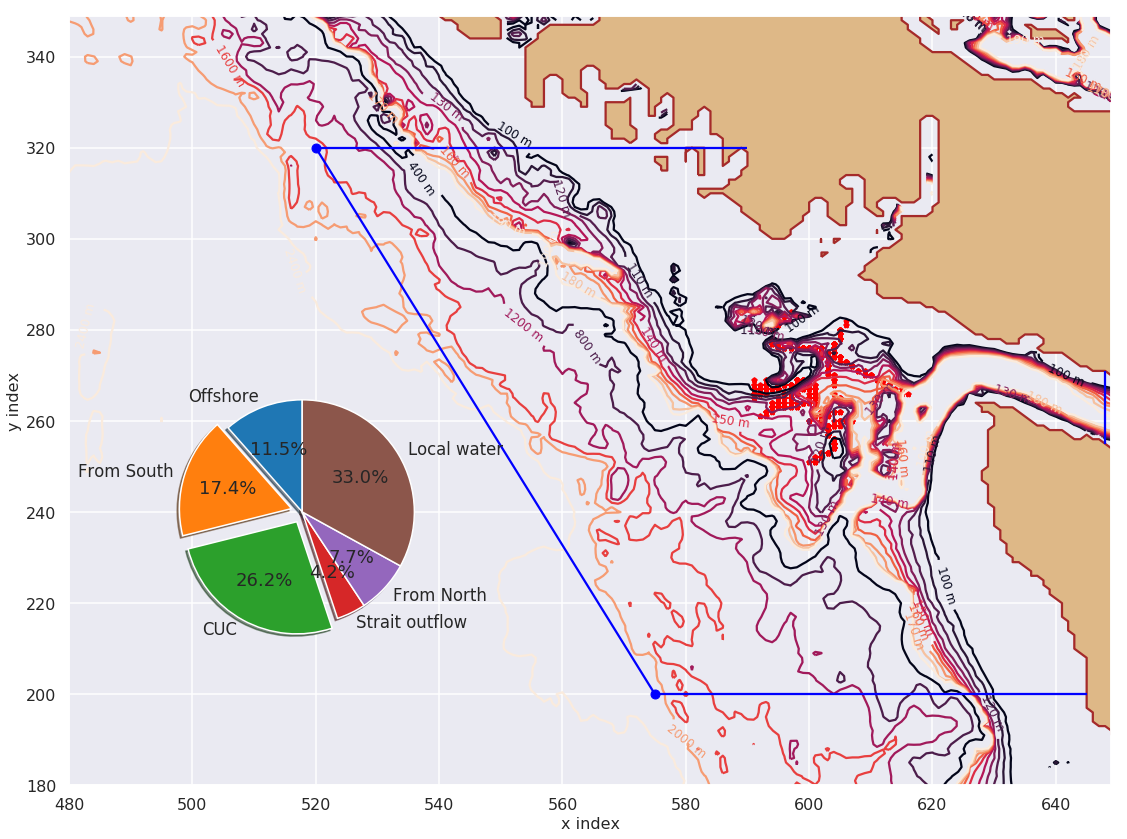

In [12]:
print("For particles rightly predicted by model for accurate eddy water on each isopycnal")


plot_pie_diagram(cuc_percentage=cuc_percent, juan_percentage=juan_percent, \
                 north_percentage=north_percent, south_percentage=south_percent, \
                 off_percentage=off_percent)

In [9]:
traj_tem_last   = np.empty_like(final_age_days)
traj_sal_last   = np.empty_like(final_age_days)
traj_rho_last   = np.empty_like(final_age_days)
traj_depth_last = np.empty_like(final_age_days)


traj_tem_init   = np.empty_like(final_age_days)
traj_sal_init   = np.empty_like(final_age_days)
traj_rho_init   = np.empty_like(final_age_days)
traj_depth_init = np.empty_like(final_age_days)

for r in np.arange(traj_tem_last.shape[0]):
    traj_tem_last[r]  =  traj_tem[np.int(final_age_days[r]),r]
    traj_sal_last[r]  =  traj_sal[np.int(final_age_days[r]),r]
    traj_rho_last[r]  =  traj_rho[np.int(final_age_days[r]),r]
    traj_depth_last[r] = traj_depth[np.int(final_age_days[r]),r]
    
    traj_tem_init[r]  =  traj_tem[0,r]
    traj_sal_init[r]  =  traj_sal[0,r]
    traj_rho_init[r]  =  traj_rho[0,r]    
    traj_depth_init[r]=  traj_depth[0,r] 
    

In [10]:
max_life_ind = np.array(np.where(final_age_days == np.max(final_age_days))[0])

off_ind   = off_ind
north_ind = np.where([(x_final < 580) & (y_final > 300)])[1]
south_ind = []
cuc_ind   = []


ind_all_south  = np.where(((x_final < 630) & (y_final < 200)) & \
                                      ((x_final > 580) & (y_final < 200)))[0]

for k in ind_all_south:
    if final_z[k] <= 26.3:
        south_ind = np.append(arr=south_ind, values= k)
        
    if final_z[k] > 26.3:
        cuc_ind = np.append(arr=cuc_ind, values=k)
        

juan_ind =  np.where((x_final > 648))[0]

non_local_ind = np.concatenate((off_ind, north_ind, south_ind, cuc_ind, juan_ind))

ind_local = np.setdiff1d(max_life_ind, np.unique(non_local_ind, return_index= False).astype(int), assume_unique=True)

# off_ind/

# ind_local = np.setdiff1d(max_life_ind, off_ind, assume_unique= True)

x_local_low_actual = x2[ind_local]
y_local_low_actual = y2[ind_local]

depth_local_low_actual = -traj_depth_last[ind_local]


In [11]:
count_ind = np.concatenate((ind_local, np.unique(non_local_ind, return_index= False).astype(int)))

count_ind.shape[0]/final_z.shape[0]

0.9746281714785652

In [12]:

traj_tem_final_cuc = traj_tem_last[cuc_ind.astype(int)]
traj_sal_final_cuc = traj_sal_last[cuc_ind.astype(int)]
traj_rho_final_cuc = traj_rho_last[cuc_ind.astype(int)]
traj_depth_final_cuc = traj_depth_last[cuc_ind.astype(int)]
traj_days_final_cuc = final_age_days[cuc_ind.astype(int)]/24



traj_tem_final_north = traj_tem_last[north_ind.astype(int)]
traj_sal_final_north = traj_sal_last[north_ind.astype(int)]
traj_rho_final_north = traj_rho_last[north_ind.astype(int)]
traj_depth_final_north = traj_depth_last[north_ind.astype(int)]
traj_days_final_north = final_age_days[north_ind.astype(int)]/24



traj_tem_final_south   = traj_tem_last[south_ind.astype(int)]
traj_sal_final_south   = traj_sal_last[south_ind.astype(int)]
traj_rho_final_south   = traj_rho_last[south_ind.astype(int)]
traj_depth_final_south = traj_depth_last[south_ind.astype(int)]
traj_days_final_south  = final_age_days[south_ind.astype(int)]/24


traj_tem_final_juan = traj_tem_last[juan_ind.astype(int)]
traj_sal_final_juan = traj_sal_last[juan_ind.astype(int)]
traj_rho_final_juan = traj_rho_last[juan_ind.astype(int)]
traj_depth_final_juan = traj_depth_last[juan_ind.astype(int)]
traj_days_final_juan = final_age_days[juan_ind.astype(int)]/24


traj_tem_final_local = traj_tem_last[ind_local.astype(int)]
traj_sal_final_local = traj_sal_last[ind_local.astype(int)]
traj_rho_final_local = traj_rho_last[ind_local.astype(int)]
traj_depth_final_local = traj_depth_last[ind_local.astype(int)]
traj_days_final_local = final_age_days[ind_local.astype(int)]/24




x = [510,575]
y = [320,200]

coefficients = np.polyfit(x, y, 1)
x_final_off = np.arange(x[0],x[1])
polynomial = np.poly1d(coefficients)
y_final_off = np.rint(polynomial(x_final_off))

traj_tem_final_off = []
traj_sal_final_off = []
traj_rho_final_off = []
traj_depth_final_off = []
traj_days_final_off = []

for l in np.arange(off_ind.shape[0]):

    traj_depth_final_off = np.append(arr=traj_depth_final_off, values=traj_depth_last[np.int(off_ind[l])])
    traj_days_final_off = np.append(arr=traj_days_final_off, values=final_age_days[np.int(off_ind[l])]/24)
    traj_rho_final_off   = np.append(arr=traj_rho_final_off, values=traj_rho_last[np.int(off_ind[l])])
    traj_tem_final_off   = np.append(arr=traj_tem_final_off, values=traj_tem_last[np.int(off_ind[l])])
    traj_sal_final_off   = np.append(arr=traj_sal_final_off, values=traj_sal_last[np.int(off_ind[l])])


In [17]:
pressure_loc_cuc = np.empty_like(traj_depth_final_cuc)
SA_loc_cuc       = np.empty_like(traj_depth_final_cuc)
CT_loc_cuc       = np.empty_like(traj_depth_final_cuc)
spic_loc_cuc     = np.empty_like(traj_depth_final_cuc)



for i in np.arange(traj_depth_final_cuc.shape[0]):
    
    pressure_loc_cuc[i] = gsw.p_from_z(traj_depth_final_cuc[i],np.mean(traj_lat))
    
    SA_loc_cuc[i] = gsw.SA_from_SP(traj_sal_final_cuc[i], pressure_loc_cuc[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_cuc[i] = gsw.CT_from_pt(traj_sal_final_cuc[i], traj_tem_final_cuc[i])
    
    spic_loc_cuc[i] = gsw.spiciness0(SA_loc_cuc[i], CT_loc_cuc[i])
    
pressure_loc_off = np.empty_like(traj_depth_final_off)
SA_loc_off       = np.empty_like(traj_depth_final_off)
CT_loc_off       = np.empty_like(traj_depth_final_off)
spic_loc_off     = np.empty_like(traj_depth_final_off)



for i in np.arange(traj_depth_final_off.shape[0]):
    
    pressure_loc_off[i] = gsw.p_from_z(traj_depth_final_off[i],np.mean(traj_lat))
    
    SA_loc_off[i] = gsw.SA_from_SP(traj_sal_final_off[i], pressure_loc_off[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_off[i] = gsw.CT_from_pt(traj_sal_final_off[i], traj_tem_final_off[i])
    
    spic_loc_off[i] = gsw.spiciness0(SA_loc_off[i], CT_loc_off[i])
    
pressure_loc_south = np.empty_like(traj_depth_final_south)
SA_loc_south       = np.empty_like(traj_depth_final_south)
CT_loc_south       = np.empty_like(traj_depth_final_south)
spic_loc_south     = np.empty_like(traj_depth_final_south)



for i in np.arange(traj_depth_final_south.shape[0]):
    
    pressure_loc_south[i] = gsw.p_from_z(traj_depth_final_south[i],np.mean(traj_lat))
    
    SA_loc_south[i] = gsw.SA_from_SP(traj_sal_final_south[i], pressure_loc_south[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_south[i] = gsw.CT_from_pt(traj_sal_final_south[i], traj_tem_final_south[i])
    
    spic_loc_south[i] = gsw.spiciness0(SA_loc_south[i], CT_loc_south[i])
    
pressure_loc_north= np.empty_like(traj_depth_final_north)
SA_loc_north       = np.empty_like(traj_depth_final_north)
CT_loc_north       = np.empty_like(traj_depth_final_north)
spic_loc_north     = np.empty_like(traj_depth_final_north)



for i in np.arange(traj_depth_final_north.shape[0]):
    
    pressure_loc_north[i] = gsw.p_from_z(traj_depth_final_north[i],np.mean(traj_lat))
    
    SA_loc_north[i] = gsw.SA_from_SP(traj_sal_final_north[i], pressure_loc_north[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_north[i] = gsw.CT_from_pt(traj_sal_final_north[i], traj_tem_final_north[i])
    
    spic_loc_north[i] = gsw.spiciness0(SA_loc_north[i], CT_loc_north[i])
    

pressure_loc_juan= np.empty_like(traj_depth_final_juan)
SA_loc_juan       = np.empty_like(traj_depth_final_juan)
CT_loc_juan       = np.empty_like(traj_depth_final_juan)
spic_loc_juan     = np.empty_like(traj_depth_final_juan)



for i in np.arange(traj_depth_final_juan.shape[0]):
    
    pressure_loc_juan[i] = gsw.p_from_z(traj_depth_final_juan[i],np.mean(traj_lat))
    
    SA_loc_juan[i] = gsw.SA_from_SP(traj_sal_final_juan[i], pressure_loc_juan[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_juan[i] = gsw.CT_from_pt(traj_sal_final_juan[i], traj_tem_final_juan[i])
    
    spic_loc_juan[i] = gsw.spiciness0(SA_loc_juan[i], CT_loc_juan[i])
    

In [18]:

pressure_loc_init = np.empty_like(traj_tem_init)
SA_loc_init       = np.empty_like(traj_depth_init)
CT_loc_init       = np.empty_like(traj_depth_init)
spic_loc_init     = np.empty_like(traj_depth_init)



for i in np.arange(traj_depth_init.shape[0]):
    
    pressure_loc_init[i] = gsw.p_from_z(traj_depth_init[i],np.mean(traj_lat))
    
    SA_loc_init[i] = gsw.SA_from_SP(traj_sal_init[i], pressure_loc_init[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_init[i] = gsw.CT_from_pt(traj_sal_init[i], traj_tem_init[i])
    
    spic_loc_init[i] = gsw.spiciness0(SA_loc_init[i], CT_loc_init[i])
    
    
pressure_loc_local = np.empty_like(traj_depth_final_local)
SA_loc_local       = np.empty_like(traj_depth_final_local)
CT_loc_local       = np.empty_like(traj_depth_final_local)
spic_loc_local     = np.empty_like(traj_depth_final_local)



for i in np.arange(traj_depth_final_local.shape[0]):
    
    pressure_loc_local[i] = gsw.p_from_z(traj_depth_final_local[i],np.mean(traj_lat))
    
    SA_loc_local[i] = gsw.SA_from_SP(traj_sal_final_local[i], pressure_loc_local[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_local[i] = gsw.CT_from_pt(traj_sal_final_local[i], traj_tem_final_local[i])
    
    spic_loc_local[i] = gsw.spiciness0(SA_loc_local[i], CT_loc_local[i])    
    

In [19]:
sns.set_context('poster')
sns.set_style('dark')

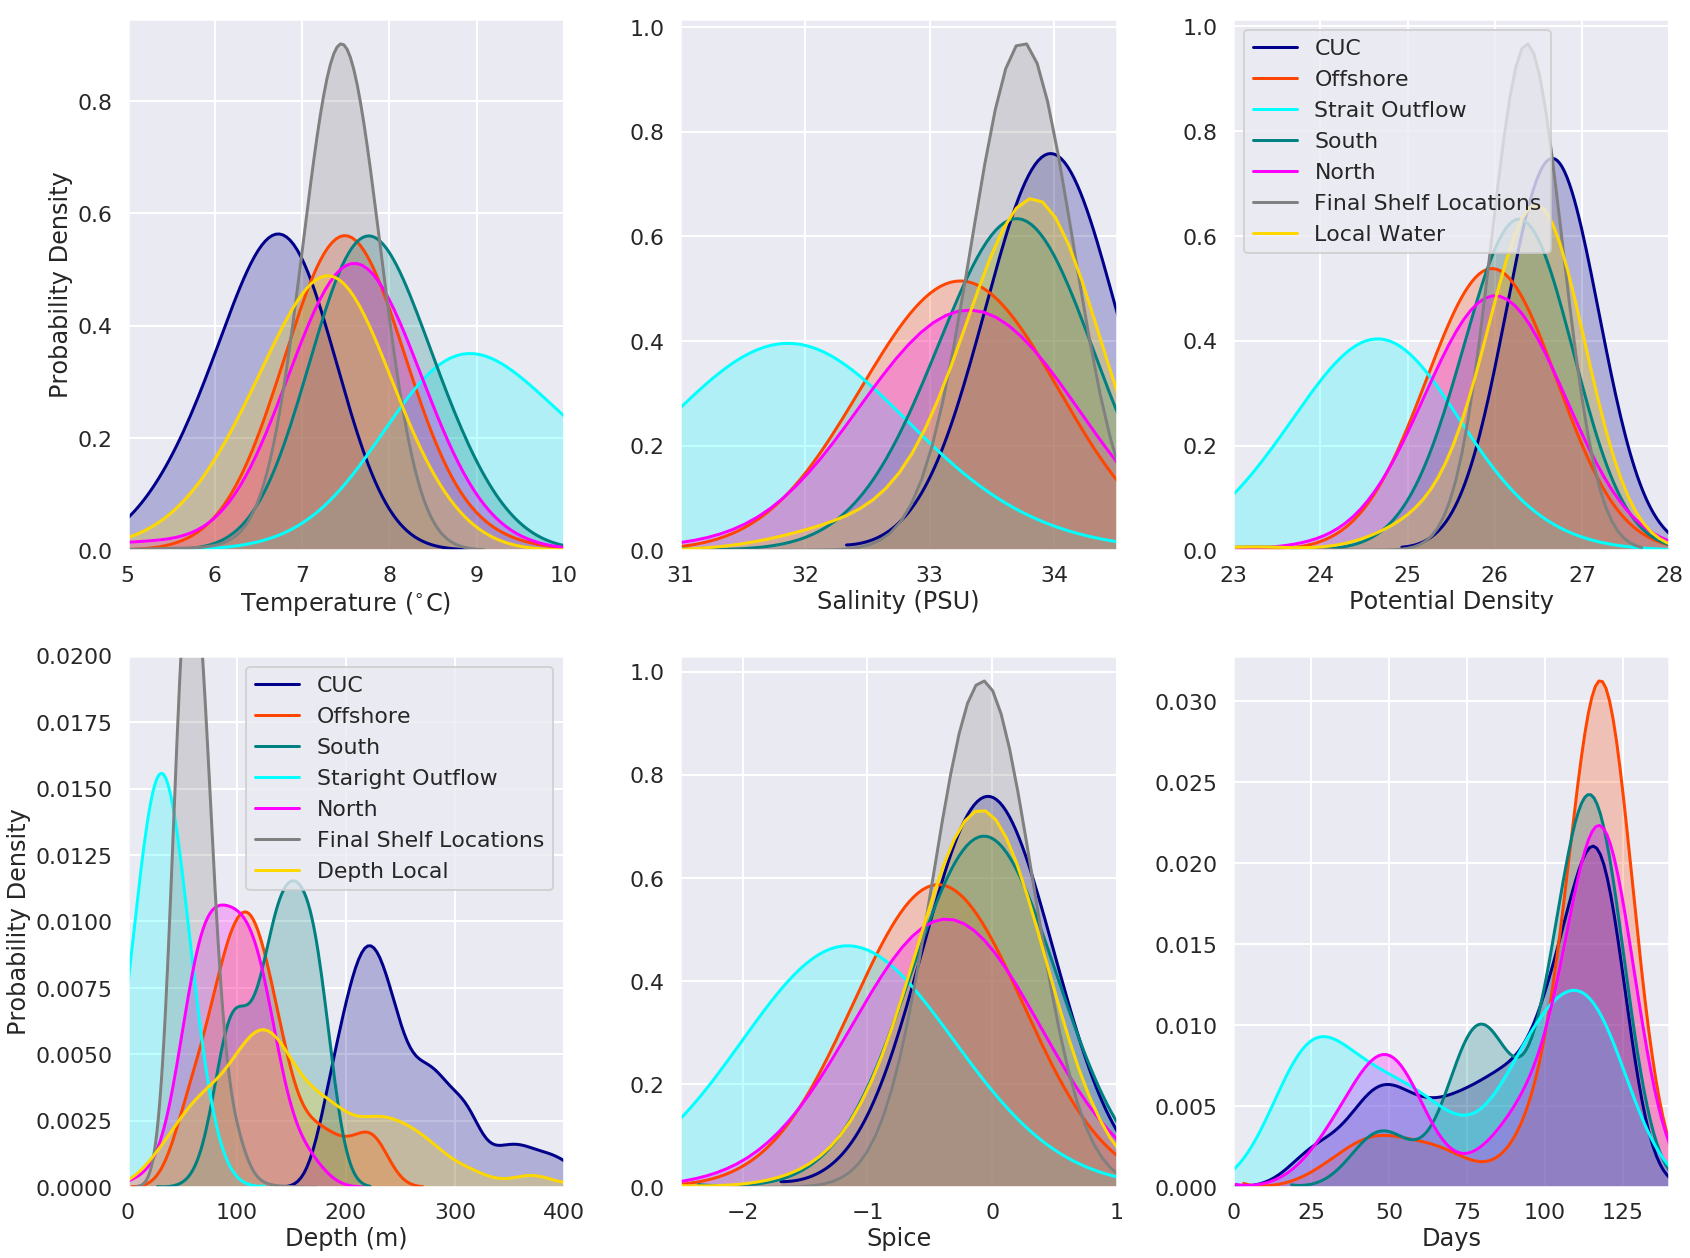

In [23]:
df = pd.DataFrame()

d = 1
local_percent = (ind_local.shape[0]/final_z.shape[0])*100

df['Density CUC']     = traj_rho_final_cuc
df['Temperature CUC'] = traj_tem_final_cuc
df['Salinity CUC']    = traj_sal_final_cuc
df['Spice CUC']       = spic_loc_cuc
df['Depth CUC']       = -traj_depth_final_cuc

dp = pd.DataFrame()

dp['Density OFF']     = traj_rho_final_off
dp['Temperature OFF'] = traj_tem_final_off
dp['Salinity OFF']    = traj_sal_final_off
dp['Spice OFF']       = spic_loc_off
dp['Depth OFF']       = -traj_depth_final_off

dg = pd.DataFrame()

dg['Density South']     = traj_rho_final_south
dg['Temperature South'] = traj_tem_final_south
dg['Salinity South']    = traj_sal_final_south
dg['Spice South']       = spic_loc_south
dg['Depth South']       = -traj_depth_final_south

dh = pd.DataFrame()

dh['Density Juan']     = traj_rho_final_juan
dh['Temperature Juan'] = traj_tem_final_juan
dh['Salinity Juan']    = traj_sal_final_juan
dh['Spice Juan']       = spic_loc_juan
dh['Depth Juan']       = -traj_depth_final_juan


dq = pd.DataFrame()

dq['Density North']     = traj_rho_final_north
dq['Temperature North'] = traj_tem_final_north
dq['Salinity North']    = traj_sal_final_north
dq['Spice North']       = spic_loc_north
dq['Depth North']       = -traj_depth_final_north


da = pd.DataFrame()

da['Density Init']     = traj_rho_init
da['Temperature Init'] = traj_tem_init
da['Salinity Init']    = traj_sal_init
da['Spice Init']       = spic_loc_init
da['Depth Init']       = -traj_depth_init

dj = pd.DataFrame()

dj['Density Local']     = traj_rho_final_local
dj['Temperature Local'] = traj_tem_final_local
dj['Salinity Local']    = traj_sal_final_local
dj['Spice Local']       = spic_loc_local
dj['Depth Local']       = -traj_depth_final_local


fig, (ax1,ax2) = plt.subplots(2,3, figsize=(24,18), sharey = False)

q = sns.kdeplot(df['Temperature CUC'], ax = ax1[0],bw=(cuc_percent**(-1./(d+4))),shade=True, color = 'darkblue', label = 'CUC')

sns.kdeplot(dp['Temperature OFF'], ax = ax1[0], bw=(off_percent**(-1./(d+4))),shade=True, color = 'orangered', label = 'Offshore')

sns.kdeplot(dh['Temperature Juan'], ax = ax1[0], bw=(juan_percent**(-1./(d+4))), shade= True, color = 'Cyan', label = 'Strait Outflow')

sns.kdeplot(dg['Temperature South'], ax = ax1[0], bw=(south_percent**(-1./(d+4))),shade=True, color = 'Teal', label = 'South')

sns.kdeplot(dq['Temperature North'], ax = ax1[0], bw=(north_percent**(-1./(d+4))),shade=True, color = 'Magenta', label = 'North')

sns.kdeplot(da['Temperature Init'], ax = ax1[0], bw =(100**(-1./(d+4))), shade=True, color = 'Gray', label = None)

sns.kdeplot(dj['Temperature Local'], ax = ax1[0], bw =(local_percent**(-1./(d+4))), shade=True, color = 'Gold', label = None)


ax1[0].set_xlim(5,10)
ax1[0].set_xlabel('Temperature ($^{\circ}$C)')
ax1[0].set_ylabel('Probability Density')
ax1[0].get_legend().remove()
ax1[0].grid()


q = sns.kdeplot(df['Salinity CUC'], ax = ax1[1], bw=(cuc_percent**(-1./(d+4))),  shade=True, color = 'darkblue', label = 'CUC')

sns.kdeplot(dp['Salinity OFF'], ax = ax1[1], bw = (off_percent**(-1./(d+4))),  shade=True,color = 'orangered', label = 'Offshore')

sns.kdeplot(dh['Salinity Juan'], ax = ax1[1], bw = (juan_percent**(-1./(d+4))), shade= True, color = 'Cyan', label = 'Strait Outflow')

sns.kdeplot(dg['Salinity South'], ax = ax1[1],  bw = (south_percent**(-1./(d+4))), shade=True, color = 'Teal', label = 'South')

sns.kdeplot(dq['Salinity North'], ax = ax1[1],bw = (north_percent**(-1./(d+4))), shade=True, color = 'Magenta', label = 'North')

sns.kdeplot(da['Salinity Init'], ax = ax1[1], bw = (100**(-1./(d+4))), shade=True, color = 'Gray',label = None)

sns.kdeplot(dj['Salinity Local'], ax = ax1[1], bw =(local_percent**(-1./(d+4))), shade=True, color = 'Gold', label = None)

# p = sns.relplot(x="Observed_temp", y="Model_temp", hue="Depth (m)",  sizes=(1,10), data=df, legend='brief', palette=cmo.cm.amp_r)

# q.figure.axes[-1].yaxis.label.set_size(16)
# q.figure.axes[-1].tick_params(labelsize=16) 


# ax1.legend()
# ax1.tick_params(axis='both',labelsize =16)
# ax1.set_xlabel('Temperature', fontsize = 16)
# ax1.set_ylabel('Density', fontsize = 16)
ax1[1].set_xlim(31,34.5)
ax1[1].set_xlabel('Salinity (PSU)')
# ax2.set_ylabel('Density')
ax1[1].grid()
# ax1[2].legend()
ax1[1].get_legend().remove()


q = sns.kdeplot(df['Density CUC'], ax = ax1[2], bw=(cuc_percent**(-1./(d+4))), shade=True, color = 'darkblue', label = 'CUC')

sns.kdeplot(dp['Density OFF'], ax = ax1[2],bw=(off_percent**(-1./(d+4))) ,shade=True,color = 'orangered', label = 'Offshore')

sns.kdeplot(dh['Density Juan'], ax = ax1[2], bw=(juan_percent**(-1./(d+4))),shade= True, color = 'Cyan', label = 'Strait Outflow')

sns.kdeplot(dg['Density South'], ax = ax1[2], bw=(south_percent**(-1./(d+4))), shade=True, color = 'Teal', label = 'South')

sns.kdeplot(dq['Density North'], ax = ax1[2], bw=(north_percent**(-1./(d+4))),shade=True, color = 'Magenta', label = 'North')

sns.kdeplot(da['Density Init'], ax = ax1[2], bw=(100**(-1./(d+4))), shade=True, color = 'Gray',label = 'Final Shelf Locations')

sns.kdeplot(dj['Density Local'], ax = ax1[2], bw =(local_percent**(-1./(d+4))), shade=True, color = 'Gold', label = 'Local Water')

# p = sns.relplot(x="Observed_temp", y="Model_temp", hue="Depth (m)",  sizes=(1,10), data=df, legend='brief', palette=cmo.cm.amp_r)

# q.figure.axes[-1].yaxis.label.set_size(16)
# q.figure.axes[-1].tick_params(labelsize=16) 


# ax1.legend()
# ax1.tick_params(axis='both',labelsize =16)
# ax1.set_xlabel('Temperature', fontsize = 16)
# ax1.set_ylabel('Density', fontsize = 16)
ax1[2].set_xlim(23,28)
ax1[2].set_xlabel('Potential Density')
# ax2.set_ylabel('Density')
ax1[2].grid()
ax1[2].legend()
# ax1[2].get_legend().remove()


q = sns.kdeplot(df['Depth CUC'], ax = ax2[0], bw=((cuc_percent/10000000)**(-1./(d+4))), shade=True, color = 'darkblue', label = 'CUC')

sns.kdeplot(dp['Depth OFF'], ax = ax2[0], bw=((off_percent/10000000)**(-1./(d+4))), shade=True, color = 'orangered', label = 'Offshore')

sns.kdeplot(dg['Depth South'], ax = ax2[0], bw=((south_percent/10000000)**(-1./(d+4))), shade= True, color = 'Teal', label = 'South')

sns.kdeplot(dh['Depth Juan'], ax = ax2[0], bw=((juan_percent/10000000)**(-1./(d+4))),  shade=True, color = 'Cyan', label = 'Staright Outflow')

sns.kdeplot(dq['Depth North'], ax = ax2[0],  bw=((north_percent/10000000)**(-1./(d+4))), shade=True, color = 'Magenta', label = 'North')

sns.kdeplot(da['Depth Init'], ax = ax2[0], bw=((100/10000000)**(-1./(d+4))), shade=True, color = 'Gray', label = 'Final Shelf Locations')

sns.kdeplot(dj['Depth Local'], ax = ax2[0], bw =(local_percent/0.05**(-1./(d+4))), shade=True, color = 'Gold', label = None)

# p = sns.relplot(x="Observed_temp", y="Model_temp", hue="Depth (m)",  sizes=(1,10), data=df, legend='brief', palette=cmo.cm.amp_r)

# q.figure.axes[-1].yaxis.label.set_size(16)
# q.figure.axes[-1].tick_params(labelsize=16) 

# lims = [
#     np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
#     np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
# ]


# ax2[0].legend()
# ax1.tick_params(axis='both',labelsize =16)
# ax1.set_xlabel('Temperature', fontsize = 16)
# ax1.set_ylabel('Density', fontsize = 16)
# ax1.set_xlim(6,14)
ax2[0].set_xlabel('Depth (m)')
ax2[0].set_ylabel('Probability Density')
ax2[0].grid()

ax2[0].set_xlim(0,400)
ax2[0].set_ylim(0,0.02)
# ax2[0].get_legend().remove()
ax2[0].legend()


q = sns.kdeplot(df['Spice CUC'], ax = ax2[1], bw=(cuc_percent**(-1./(d+4))), shade=True, color = 'darkblue', label = 'CUC')

sns.kdeplot(dp['Spice OFF'], ax = ax2[1], bw=(off_percent**(-1./(d+4))), shade=True,color = 'orangered', label = 'Offshore')

sns.kdeplot(dh['Spice Juan'], ax = ax2[1], bw=(juan_percent**(-1./(d+4))), shade= True, color = 'Cyan', label = 'Strait Outflow')

sns.kdeplot(dg['Spice South'], ax = ax2[1],  bw=(south_percent**(-1./(d+4))), shade=True, color = 'Teal', label = 'South')

sns.kdeplot(dq['Spice North'], ax = ax2[1],  bw=(north_percent**(-1./(d+4))),shade=True, color = 'Magenta', label = 'North')

sns.kdeplot(da['Spice Init'], ax = ax2[1], bw=(100**(-1./(d+4))), shade=True, color = 'Gray', label = 'Final Shelf Locations')

sns.kdeplot(dj['Spice Local'], ax = ax2[1], bw =(local_percent**(-1./(d+4))), shade=True, color = 'Gold', label = 'Local Water')


# p = sns.relplot(x="Observed_temp", y="Model_temp", hue="Depth (m)",  sizes=(1,10), data=df, legend='brief', palette=cmo.cm.amp_r)

# q.figure.axes[-1].yaxis.label.set_size(16)
# q.figure.axes[-1].tick_params(labelsize=16) 


# ax1.legend()
# ax1.tick_params(axis='both',labelsize =16)
# ax1.set_xlabel('Temperature', fontsize = 16)
# ax1.set_ylabel('Density', fontsize = 16)
ax2[1].set_xlim(-2.5,1)
ax2[1].set_xlabel('Spice')
# ax2.set_ylabel('Density')
ax2[1].grid()
# ax2[1].legend()
ax2[1].get_legend().remove()




df = pd.DataFrame()

df['Days CUC']     = traj_days_final_cuc


dp = pd.DataFrame()

dp['Days OFF']     = traj_days_final_off


dg = pd.DataFrame()

dg['Days South']     = traj_days_final_south


dh = pd.DataFrame()

dh['Days Juan']     = traj_days_final_juan

dz = pd.DataFrame()

dz['Days North']    = traj_days_final_north

dn = pd.DataFrame()

dn['Days Local'] = traj_days_final_local




q = sns.kdeplot(df['Days CUC'], ax = ax2[2],  bw=((cuc_percent/1000000)**(-1./(d+4))), shade=True, color = 'darkblue', label = 'CUC')

sns.kdeplot(dp['Days OFF'], ax = ax2[2], bw=((off_percent/1000000)**(-1./(d+4))), shade=True, color = 'orangered', label = 'Offshore')

sns.kdeplot(dg['Days South'], ax = ax2[2], bw=((south_percent/1000000)**(-1./(d+4))), shade= True, color = 'Teal', label = 'South')

sns.kdeplot(dh['Days Juan'], ax = ax2[2], bw=((juan_percent/1000000)**(-1./(d+4))), shade=True, color = 'Cyan', label = 'Strait Outflow')

sns.kdeplot(dz['Days North'], ax = ax2[2],  bw=((north_percent/1000000)**(-1./(d+4))), shade=True, color = 'Magenta', label = 'North')

# sns.kdeplot(dn['Days Local'], ax = ax2[2], bw =(local_percent/0.001**(-1./(d+4))), shade=True, color = 'Gold', label = None)

# p = sns.relplot(x="Observed_temp", y="Model_temp", hue="Depth (m)",  sizes=(1,10), data=df, legend='brief', palette=cmo.cm.amp_r)

# q.figure.axes[-1].yaxis.label.set_size(16)
# q.figure.axes[-1].tick_params(labelsize=16) 



# ax1.legend()
# ax1.tick_params(axis='both',labelsize =16)
# ax1.set_xlabel('Temperature', fontsize = 16)
# ax1.set_ylabel('Density', fontsize = 16)
# ax1.set_xlim(6,14)
ax2[2].set_xlabel('Days')
# ax1.set_ylabel('Probability Density')
ax2[2].grid()
ax2[2].get_legend().remove()
# ax2[2].legend()

ax2[2].set_xlim(0,140)

fig.tight_layout()


In [26]:
local_water_x_1 = x2[~((np.where(final_age_days[(x_final < 580) & (y_final > 300)] == np.max(final_age_days)))[0])]

local_water_y_1 = y2[~((np.where(final_age_days[(x_final < 580) & (y_final > 300)] == np.max(final_age_days)))[0])]


local_water_x_2 = x2[~((np.where(final_age_days[np.where(final_z[((x_final < 630) & (y_final < 200)) & \
                                      ((x_final > 580) & (y_final < 200))]>26.3)[0]] == np.max(final_age_days)))[0])]
local_water_y_2 = y2[~((np.where(final_age_days[np.where(final_z[((x_final < 630) & (y_final < 200)) & \
                                      ((x_final > 580) & (y_final < 200))]>26.3)[0]] == np.max(final_age_days)))[0])]


local_water_x_3 = x2[~((np.where(final_age_days[np.where(final_z[((x_final < 630) & (y_final < 200)) & \
                                      ((x_final > 580) & (y_final < 200))]<=26.3)[0]] == np.max(final_age_days)))[0])]
local_water_y_3 = y2[~((np.where(final_age_days[np.where(final_z[((x_final < 630) & (y_final < 200)) & \
                                      ((x_final > 580) & (y_final < 200))]<=26.3)[0]] == np.max(final_age_days)))[0])]


local_water_x_4 = x2[~(off_ind.astype(int))]
local_water_y_4 = y2[~(off_ind.astype(int))]

local_water_x_5 = x2[~(np.where(final_age_days[np.where((x_final > 648))[0]] == np.max(final_age_days))[0])]
local_water_y_5 = y2[~(np.where(final_age_days[np.where((x_final > 648))[0]] == np.max(final_age_days))[0])]

local_water_ind_x = np.concatenate((local_water_x_1, local_water_x_2, local_water_x_3, local_water_x_4, \
                                  local_water_x_5))
local_water_ind_y = np.concatenate((local_water_y_1, local_water_y_2, local_water_y_3, local_water_y_4, \
                                  local_water_y_5))

In [31]:
sns.set_style('darkgrid')

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


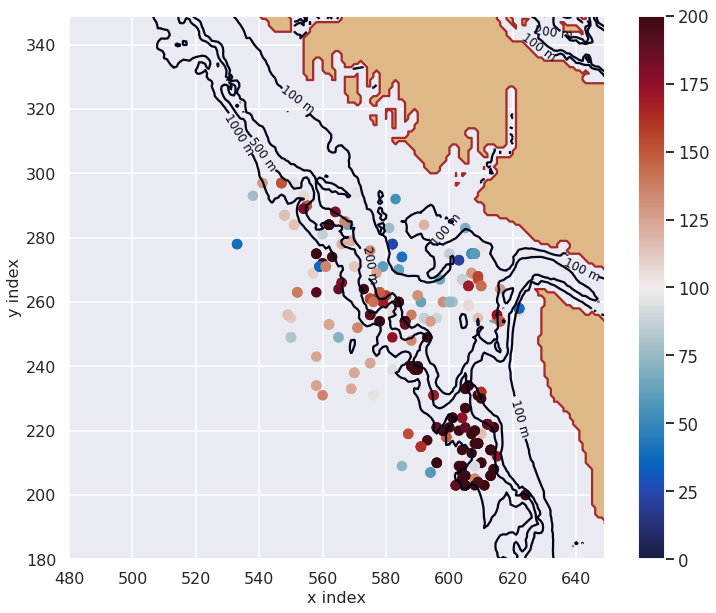

In [14]:
from scipy.interpolate import interpn
from mpl_toolkits.axes_grid1 import make_axes_locatable





cmap = plt.get_cmap(cmo.cm.balance)


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]

vmin = 0
vmax = 200


# cmap=plt.cm.get_cmap('nipy_spectral')
# cmap = plt.cm.get_cmap('gist_rainbow_r')
cmap.set_bad('#8b7765')


import matplotlib as mpl
#     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

fig, ax = plt.subplots(1, 1, figsize=(12,10)); ax.grid()
# CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,200,10))
# CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
# CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
# CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,110,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(200,210,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(1000,1010,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(500,510,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)



ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)


# ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
ax.legend(loc = 'best')

viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')


# ax.get_legend().remove()
lon_LB08 = -125.4775
lat_LB08 = 48.4217

j, i = geo_tools.find_closest_model_point(lon_LB08,lat_LB08,\
                                          lon,lat,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 

# q = density_scatter(x_wcvi_slice[np.round(x_local, decimals=0).astype(int)-1], \
#                     y_wcvi_slice[np.round(y_local, decimals=0).astype(int)-1], ax= ax, bins = [30,30], cmap = cmap , vmin = vmin, vmax = vmax)
# q = ax.scatter(x_wcvi_slice[np.round(local_water_ind_x[np.isnan(local_water_ind_x) == False], decimals=0).astype(int)-1], \
#                     y_wcvi_slice[np.round(local_water_ind_y[np.isnan(local_water_ind_y) == False], decimals=0).astype(int)-1], cmap = cmap , vmin = vmin, vmax = vmax)

q = ax.scatter(x_wcvi_slice[np.round(x_local_low_actual, decimals=0).astype(int)-1], \
                    y_wcvi_slice[np.round(y_local_low_actual, decimals=0).astype(int)-1], \
               c =  depth_local_low_actual, cmap = cmap , vmin = vmin, vmax = vmax)

# for k in np.arange(x1.shape[0]):
#     ax.scatter(x_wcvi_slice[np.int(x_high[k]-1)],y_wcvi_slice[np.int(y_high[k]-1)], marker = '*', alpha=0.2, c = 'red', s = 10, linewidths=3)

# ax.hlines(y = 200, xmin = 575, xmax=645, color = 'b')
# ax.hlines(y = 320, xmin = 520, xmax=590, color = 'b')
ax.grid()

# cbar = fig.colorbar(q, cax =ax)

# for i in range(0, len(x_200_wcvi), 10):
#     plt.plot(x_200_wcvi[i:i+1], y_200_wcvi[i:i+1], 'mo-')
    

# Line = ax.plot(x_200_wcvi[::1], y_200_wcvi[::1], 'k-')

# plt.colorbar(q)
# colorbar(q)

m = cm.ScalarMappable(cmap=cmap)
m.set_array(q)
m.set_clim(vmin,vmax)
plt.colorbar(m)





### Replace this with a subplot showing both eddy and the south outer shelf water

In [15]:
ind_local.shape

(377,)

(5, 12)

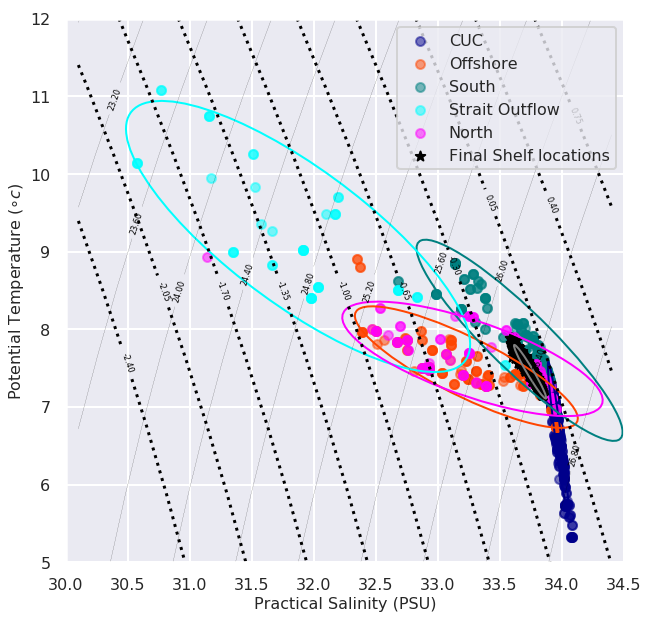

In [35]:
# colors = cmo.cm.phase(np.linspace(0, 1, 200))


# traj_sal_domain = traj_sal[traj_sal != 1.0100000202412861e+20]
# traj_tem_domain = traj_tem[traj_sal != 1.0100000202412861e+20]

# smin = np.nanmin(traj_sal_last)  - (0.01 * np.nanmin(traj_sal_last))
smin = 30
smax = np.nanmax(traj_sal_last)  + (0.01 * np.nanmax(traj_sal_last))
# tmin = np.nanmin(traj_tem_last) - (0.1 * np.nanmax(traj_tem_last))
tmin = 4
tmax = 12
# tmax = np.nanmax(traj_tem_last) + (0.1 * np.nanmax(traj_tem_last))
 
# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens_1 = np.empty((ydim,xdim))
spic_1 = np.empty((ydim,xdim))
SA = np.empty((xdim))
CT = np.empty((ydim)) 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        
        SA[i] = gsw.SA_from_SP(si[i], 0, np.mean(traj_lon), np.mean(traj_lat))

        CT[j] = gsw.CT_from_pt(si[i], ti[j])
        
        dens_1[j,i]=gsw.rho(SA[i],CT[j],0)
        
        spic_1[j,i] = gsw.spiciness0(SA[i],CT[j])
 
# Substract 1000 to convert to sigma-t
dens_1 = dens_1 - 1000;
 
# Plot data ***********************************************
fig1, ax = plt.subplots(1, 1, figsize=(10,10))
CS = ax.contour(si,ti,dens_1, np.arange(22.4,27,0.4), linestyles='dashed', linewidths = 0.2,colors='k')
CS1 = ax.contour(si,ti,spic_1,np.arange(-2.4,1,0.35), linestyles='dotted', colors='k')
plt.clabel(CS, fontsize=8, inline=1, fmt='%0.2f') # Label every second level
plt.clabel(CS1, fontsize=8, inline=1, fmt='%0.2f') # Label every second level



ax.scatter(traj_sal_final_cuc, traj_tem_final_cuc, s=80, alpha=0.5, c = 'darkblue', label = 'CUC')
sal_mean_cuc = np.mean(traj_sal_final_cuc)
tem_mean_cuc = np.mean(traj_tem_final_cuc)
cov_cuc = np.cov(traj_sal_final_cuc, traj_tem_final_cuc)
cuc_ell = get_cov_ellipse(cov_cuc, (sal_mean_cuc, tem_mean_cuc), 2,
                    ec='darkblue', fc = None)
cuc_ell.set_facecolor('none')
ax.add_artist(cuc_ell)




ax.scatter(traj_sal_final_off, traj_tem_final_off, s=80, alpha=0.5, c = 'orangered', label = 'Offshore')
sal_mean_off = np.mean(traj_sal_final_off)
tem_mean_off = np.mean(traj_tem_final_off)
cov_off = np.cov(traj_sal_final_off, traj_tem_final_off)
off_ell = get_cov_ellipse(cov_off, (sal_mean_off, tem_mean_off), 2,
                    ec='orangered', fc = None)
off_ell.set_facecolor('none')
ax.add_artist(off_ell)


traj_tem_final_north = traj_tem_final_north[traj_sal_final_north > 30]
traj_sal_final_north = traj_sal_final_north[traj_sal_final_north > 30]

ax.scatter(traj_sal_final_south, traj_tem_final_south, s=80, alpha=0.5, c= 'Teal', label = 'South')
sal_mean_south = np.mean(traj_sal_final_south)
tem_mean_south = np.mean(traj_tem_final_south)
cov_south = np.cov(traj_sal_final_south, traj_tem_final_south)
south_ell = get_cov_ellipse(cov_south, (sal_mean_south, tem_mean_south), 3,
                    ec='Teal', fc = None)
south_ell.set_facecolor('none')
ax.add_artist(south_ell)




# traj_tem_final_juan = traj_tem_final_juan[traj_sal_final_juan < 32.8]
# traj_sal_final_juan = traj_sal_final_juan[traj_sal_final_juan < 32.8]

ax.scatter(traj_sal_final_juan, traj_tem_final_juan, s=80, alpha=0.5, c = 'cyan', label = 'Strait Outflow')
sal_mean_juan = np.mean(traj_sal_final_juan)
tem_mean_juan = np.mean(traj_tem_final_juan)
cov_juan = np.cov(traj_sal_final_juan, traj_tem_final_juan)
juan_ell = get_cov_ellipse(cov_juan, (sal_mean_juan, tem_mean_juan), 2,
                    fc = None, ec='cyan')
juan_ell.set_facecolor('none')
ax.add_artist(juan_ell)




ax.scatter(traj_sal_final_north, traj_tem_final_north, s=80, alpha=0.5, c = 'Magenta', label = 'North')
sal_mean_north = np.mean(traj_sal_final_north)
tem_mean_north = np.mean(traj_tem_final_north)
cov_north = np.cov(traj_sal_final_north, traj_tem_final_north)
north_ell = get_cov_ellipse(cov_north, (sal_mean_north, tem_mean_north), 2,
                    ec='Magenta', fc = None)
north_ell.set_facecolor('none')
ax.add_artist(north_ell)


traj_tem_init = traj_tem_init[traj_sal_init > 30]
traj_sal_init = traj_sal_init[traj_sal_init > 30]

ax.scatter(traj_sal_init, traj_tem_init, s=100, marker='*', c = 'k', label = "Final Shelf locations")#'chartreuse')
sal_mean_init = np.mean(traj_sal_init)
tem_mean_init = np.mean(traj_tem_init)
cov_init = np.cov(traj_sal_init, traj_tem_init)
init_ell = get_cov_ellipse(cov_init, (sal_mean_init, tem_mean_init), 2,
                    ec='gray', fc = None)
init_ell.set_facecolor('none')
ax.add_artist(init_ell)


ax.legend(loc = 'best', fontsize = 16)


 
ax.set_xlabel('Practical Salinity (PSU)', fontsize = 16)
ax.set_ylabel('Potential Temperature ($\circ c$)', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)
ax.set_xlim(30,34.5)
ax.set_ylim(5,12)


# legend = ax.legend(loc='upper right', fancybox=True, framealpha=0.25)

(5, 12)

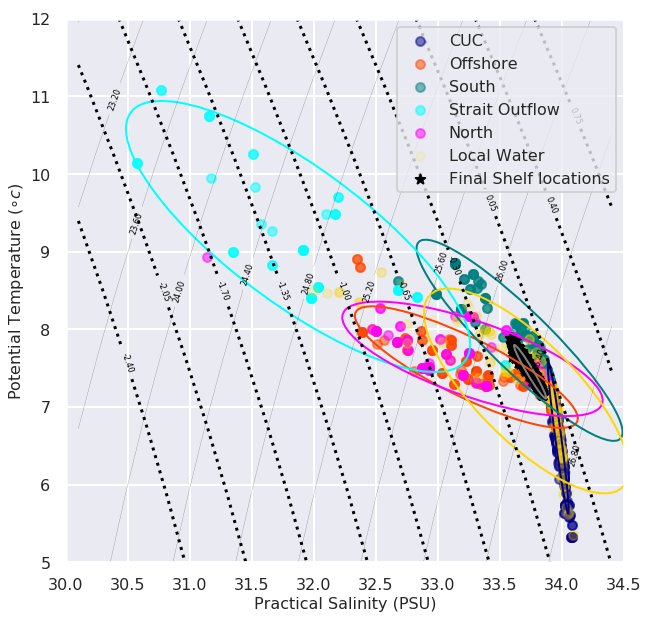

In [50]:
# colors = cmo.cm.phase(np.linspace(0, 1, 200))


# traj_sal_domain = traj_sal[traj_sal != 1.0100000202412861e+20]
# traj_tem_domain = traj_tem[traj_sal != 1.0100000202412861e+20]

# smin = np.nanmin(traj_sal_last)  - (0.01 * np.nanmin(traj_sal_last))
smin = 30
smax = np.nanmax(traj_sal_last)  + (0.01 * np.nanmax(traj_sal_last))
# tmin = np.nanmin(traj_tem_last) - (0.1 * np.nanmax(traj_tem_last))
tmin = 4
tmax = 12
# tmax = np.nanmax(traj_tem_last) + (0.1 * np.nanmax(traj_tem_last))
 
# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens_1 = np.empty((ydim,xdim))
spic_1 = np.empty((ydim,xdim))
SA = np.empty((xdim))
CT = np.empty((ydim)) 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        
        SA[i] = gsw.SA_from_SP(si[i], 0, np.mean(traj_lon), np.mean(traj_lat))

        CT[j] = gsw.CT_from_pt(si[i], ti[j])
        
        dens_1[j,i]=gsw.rho(SA[i],CT[j],0)
        
        spic_1[j,i] = gsw.spiciness0(SA[i],CT[j])
 
# Substract 1000 to convert to sigma-t
dens_1 = dens_1 - 1000;
 
# Plot data ***********************************************
fig1, ax = plt.subplots(1, 1, figsize=(10,10))
CS = ax.contour(si,ti,dens_1, np.arange(22.4,27,0.4), linestyles='dashed', linewidths = 0.2,colors='k')
CS1 = ax.contour(si,ti,spic_1,np.arange(-2.4,1,0.35), linestyles='dotted', colors='k')
plt.clabel(CS, fontsize=8, inline=1, fmt='%0.2f') # Label every second level
plt.clabel(CS1, fontsize=8, inline=1, fmt='%0.2f') # Label every second level



ax.scatter(traj_sal_final_cuc, traj_tem_final_cuc, s=80, alpha=0.5, c = 'darkblue', label = 'CUC')
sal_mean_cuc = np.mean(traj_sal_final_cuc)
tem_mean_cuc = np.mean(traj_tem_final_cuc)
cov_cuc = np.cov(traj_sal_final_cuc, traj_tem_final_cuc)
cuc_ell = get_cov_ellipse(cov_cuc, (sal_mean_cuc, tem_mean_cuc), 2,
                    ec='darkblue', fc = None)
cuc_ell.set_facecolor('none')
ax.add_artist(cuc_ell)




ax.scatter(traj_sal_final_off, traj_tem_final_off, s=80, alpha=0.5, c = 'orangered', label = 'Offshore')
sal_mean_off = np.mean(traj_sal_final_off)
tem_mean_off = np.mean(traj_tem_final_off)
cov_off = np.cov(traj_sal_final_off, traj_tem_final_off)
off_ell = get_cov_ellipse(cov_off, (sal_mean_off, tem_mean_off), 2,
                    ec='orangered', fc = None)
off_ell.set_facecolor('none')
ax.add_artist(off_ell)


traj_tem_final_north = traj_tem_final_north[traj_sal_final_north > 30]
traj_sal_final_north = traj_sal_final_north[traj_sal_final_north > 30]

ax.scatter(traj_sal_final_south, traj_tem_final_south, s=80, alpha=0.5, c= 'Teal', label = 'South')
sal_mean_south = np.mean(traj_sal_final_south)
tem_mean_south = np.mean(traj_tem_final_south)
cov_south = np.cov(traj_sal_final_south, traj_tem_final_south)
south_ell = get_cov_ellipse(cov_south, (sal_mean_south, tem_mean_south), 3,
                    ec='Teal', fc = None)
south_ell.set_facecolor('none')
ax.add_artist(south_ell)




# traj_tem_final_juan = traj_tem_final_juan[traj_sal_final_juan < 32.8]
# traj_sal_final_juan = traj_sal_final_juan[traj_sal_final_juan < 32.8]

ax.scatter(traj_sal_final_juan, traj_tem_final_juan, s=80, alpha=0.5, c = 'cyan', label = 'Strait Outflow')
sal_mean_juan = np.mean(traj_sal_final_juan)
tem_mean_juan = np.mean(traj_tem_final_juan)
cov_juan = np.cov(traj_sal_final_juan, traj_tem_final_juan)
juan_ell = get_cov_ellipse(cov_juan, (sal_mean_juan, tem_mean_juan), 2,
                    fc = None, ec='cyan')
juan_ell.set_facecolor('none')
ax.add_artist(juan_ell)




ax.scatter(traj_sal_final_north, traj_tem_final_north, s=80, alpha=0.5, c = 'Magenta', label = 'North')
sal_mean_north = np.mean(traj_sal_final_north)
tem_mean_north = np.mean(traj_tem_final_north)
cov_north = np.cov(traj_sal_final_north, traj_tem_final_north)
north_ell = get_cov_ellipse(cov_north, (sal_mean_north, tem_mean_north), 2,
                    ec='Magenta', fc = None)
north_ell.set_facecolor('none')
ax.add_artist(north_ell)

traj_tem_final_local = traj_tem_final_local[traj_sal_final_local > 30]
traj_sal_final_local = traj_sal_final_local[traj_sal_final_local > 30]

ax.scatter(traj_sal_final_local, traj_tem_final_local, s=80, alpha=0.1, c = 'Gold', label = 'Local Water')
sal_mean_local = np.mean(traj_sal_final_local)
tem_mean_local = np.mean(traj_tem_final_local)
cov_local = np.cov(traj_sal_final_local, traj_tem_final_local)
local_ell = get_cov_ellipse(cov_local, (sal_mean_local, tem_mean_local), 2,
                    ec='Gold', fc = None)
local_ell.set_facecolor('none')
ax.add_artist(local_ell)


traj_tem_init = traj_tem_init[traj_sal_init > 30]
traj_sal_init = traj_sal_init[traj_sal_init > 30]

ax.scatter(traj_sal_init, traj_tem_init, s=100, marker='*', c = 'k', label = "Final Shelf locations")#'chartreuse')
sal_mean_init = np.mean(traj_sal_init)
tem_mean_init = np.mean(traj_tem_init)
cov_init = np.cov(traj_sal_init, traj_tem_init)
init_ell = get_cov_ellipse(cov_init, (sal_mean_init, tem_mean_init), 2,
                    ec='gray', fc = None)
init_ell.set_facecolor('none')
ax.add_artist(init_ell)


ax.legend(loc = 'best', fontsize = 16)


 
ax.set_xlabel('Practical Salinity (PSU)', fontsize = 16)
ax.set_ylabel('Potential Temperature ($\circ c$)', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)
ax.set_xlim(30,34.5)
ax.set_ylim(5,12)


# legend = ax.legend(loc='upper right', fancybox=True, framealpha=0.25)

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


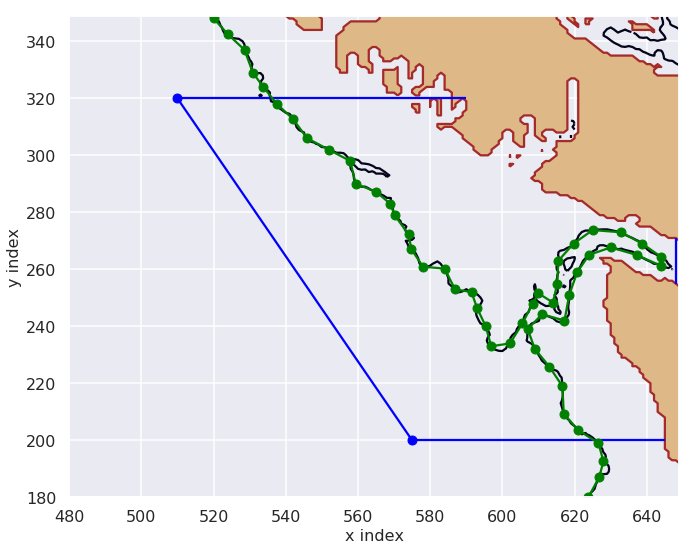

In [13]:



bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]




cmap=plt.cm.get_cmap('nipy_spectral')
#     cmap = plt.cm.get_cmap('gist_rainbow')
cmap.set_bad('#8b7765')
cmin = 0
cmax = 300

import matplotlib as mpl
#     norm = mpl.colors.Normalize(vmin=cmin,vmax=cmax)

fig, ax = plt.subplots(1, 1, figsize=(10,8)); ax.grid()
CS = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(200,210,10))
# CS1 = ax.contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], level = [0,100,200,500,1000])
# CLS = plt.clabel(CS, inline=3,fmt='%0.0f m', fontsize=12)
# CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)




ax.set_xlabel('x index', fontsize =16)
ax.set_ylabel('y index', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)


# ax.set_title('Particle track at depth \u2248 {d:.1f} m'.format(d = np.abs(traj_depth[0,part])), fontsize =16)
ax.legend(loc = 'best')

viz_tools.plot_land_mask(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
viz_tools.plot_coastline(ax, bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')

x = [510,575]
y = [320,200]
ax.plot(x, y , 'bo-')

xmin = x_wcvi_slice[np.int(np.min(np.unique(x1)))]-1
xmax = x_wcvi_slice[np.int(np.max(np.unique(x1)))]-1


ymin = y_wcvi_slice[np.int(np.min(np.unique(y1)))]-1
ymax  = y_wcvi_slice[np.int(np.max(np.unique(y1)))]-1


# x_1 = [xmin, xmax]
# y_1 = [ymin, ymin]
# ax.plot(x_1, y_1 , 'go-')

# x_2 = [xmin, xmax]
# y_2 = [ymax, ymax]
# ax.plot(x_2, y_2 , 'go-')

# x_3 = [xmin, xmin]
# y_3 = [ymin, ymax]
# ax.plot(x_3, y_3 , 'go-')

# x_4 = [xmax, xmax]
# y_4 = [ymin, ymax]
# ax.plot(x_4, y_4 , 'go-')

ax.vlines(x = 648, ymin = 255, ymax = 271, color = 'blue')

# ax.get_legend().remove()
# lon_LB08 = -125.4775
# lat_LB08 = 48.4217

# j, i = geo_tools.find_closest_model_point(lon_LB08,lat_LB08,\
#                                           lon,lat,grid='NEMO',tols=\
#                                           {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
#                                            'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 

# ax.scatter(i,j, marker = 'o', c = 'red', s = 300, linewidths=100, label = 'Eddy region')

ax.hlines(y = 200, xmin = 575, xmax=645, color = 'b')
ax.hlines(y = 320, xmin = 510, xmax=590, color = 'b')
ax.grid()

contour = CS.collections[0]
vs = contour.get_paths()[0].vertices


vert = CS.collections[0].get_paths()[0].vertices

x_200_wcvi = vert[:,0]
y_200_wcvi = vert[:,1]

# for i in range(0, len(x_200_wcvi), 10):
#     plt.plot(x_200_wcvi[i:i+1], y_200_wcvi[i:i+1], 'mo-')
    

Line = ax.plot(x_200_wcvi[::10], y_200_wcvi[::10], 'go-')
fig.tight_layout()





In [14]:
IK = find_index(500)

PK = find_index(1000)

# LK = find_index(1500)

# JK = find_index(2000)

# LI = find_index(2500)

# LP = find_index(3000)

# MN = find_index(3500)

total_indi_low = np.concatenate((IK,PK))#,LK,JK,LI, LP, MN))

In [15]:
cross_index_low = []


for i in np.unique(total_indi_low):

    if ((np.max(-traj_depth[:,i]) >= 200) & (np.min(-traj_depth[:,i]) < 200)) == True:
        
        cross_index_low = np.append(arr=cross_index_low, values=i)
        


In [16]:
percentage = cross_index_low.shape[0]/final_age_days.shape[0]

print(percentage)

0.27384076990376205


### 27.4 Percent of the Eddy water arrives at the locations by upwelling (our definition)

In [17]:
time_index_low = np.empty_like(cross_index_low)

for k in np.arange(cross_index_low.shape[0]):
    time_index_low[k] = np.min(np.argwhere(-traj_depth[:,cross_index_low[k].astype(int)] > 200))
    
    

In [24]:
np.save(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/numpy_arrays_saved/cross_index_accurate_iso_low.npy', \
        arr=cross_index_low)

np.save(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/numpy_arrays_saved/time_index_accurate_iso_low.npy',\
        arr=time_index_low)


In [18]:
x_200_total = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/numpy_arrays_saved/\
x_200_total_eddy_water_acc_iso.npy')

y_200_total  = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/numpy_arrays_saved/\
y_200_total_eddy_water_acc_iso.npy')

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


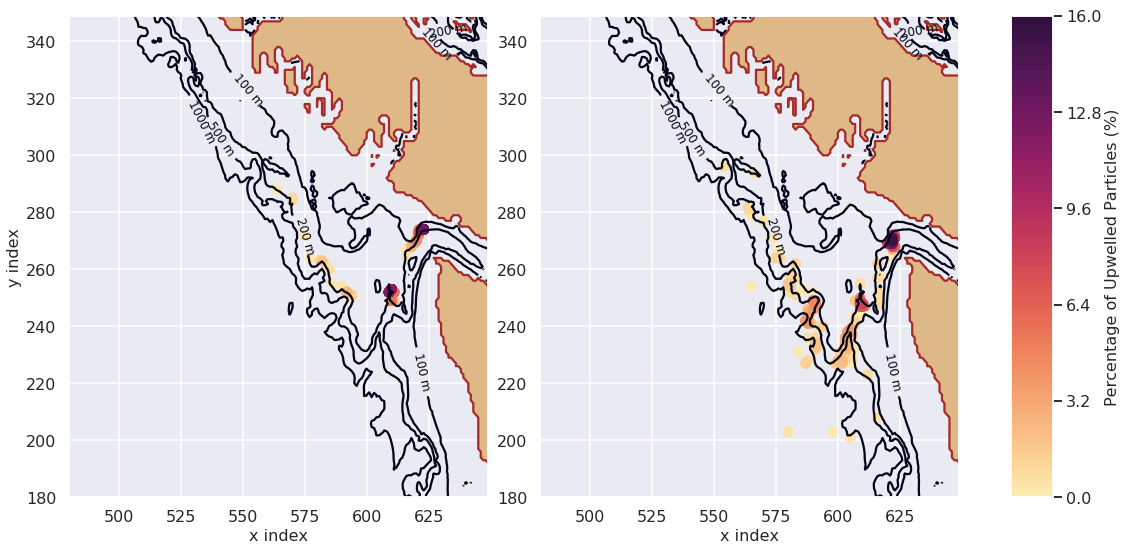

In [25]:
from scipy.interpolate import interpn
from mpl_toolkits.axes_grid1 import make_axes_locatable





cmap = plt.get_cmap(cmo.cm.matter)


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]




# cmap=plt.cm.get_cmap('nipy_spectral')
# cmap = plt.cm.get_cmap('gist_rainbow_r')
cmap.set_bad('#8b7765')
vmin = 0
vmax = 50

import matplotlib as mpl

gridspec = {'width_ratios': [1, 1, 0.1]}

fig, ax = plt.subplots(1, 3, figsize=(16, 8), gridspec_kw=gridspec)


# fig, (ax1,ax) = plt.subplots(1, 2, figsize=(12,8), sharey=True); 

ax[0].grid()

CS1 = ax[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,110,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)


CS1 = ax[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(200,210,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(1000,1010,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(500,510,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)



ax[0].set_xlabel('x index', fontsize =16)
ax[0].set_ylabel('y index', fontsize = 16)
ax[0].tick_params(axis='both',labelsize =16)

ax[0].legend(loc = 'best')

viz_tools.plot_land_mask(ax[0], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
viz_tools.plot_coastline(ax[0], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')


lon_LB08 = -125.4775
lat_LB08 = 48.4217

j, i = geo_tools.find_closest_model_point(lon_LB08,lat_LB08,\
                                          lon,lat,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 


q = density_scatter(x_200_total[~np.isnan(y_200_total)], y_200_total[~np.isnan(y_200_total)], ax= ax[0], bins = [30,30], cmap = cmap , vmin = vmin, vmax = vmax)

ax[0].grid()


# Line = ax[0].plot(x_200_wcvi[::1], y_200_wcvi[::1], 'k-')



ax[1].grid()


CS1 = ax[1].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,110,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax[1].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(200,210,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax[1].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(1000,1010,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax[1].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(500,510,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)




ax[1].set_xlabel('x index', fontsize =16)
# ax.set_ylabel('y index', fontsize = 16)
ax[1].tick_params(axis='both',labelsize =16)



ax[1].legend(loc = 'best')

viz_tools.plot_land_mask(ax[1], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
viz_tools.plot_coastline(ax[1], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')



# ax.vlines(x = 635, ymin = 261, ymax = 279, color = 'blue')

# ax.get_legend().remove()
lon_LB08 = -125.4775
lat_LB08 = 48.4217

j, i = geo_tools.find_closest_model_point(lon_LB08,lat_LB08,\
                                          lon,lat,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 


x_up = []
y_up = []

for k in np.arange(cross_index_low.shape[0]):
    y_p, x_p = geo_tools.find_closest_model_point(traj_lon[time_index_low[k].astype(int), cross_index_low[k].astype(int)],\
                                          traj_lat[time_index_low[k].astype(int), cross_index_low[k].astype(int)],\
                                          lon,lat,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 
    
    y_up = np.append(arr=y_up, values=y_p)
    x_up = np.append(arr=x_up, values=x_p)


q = density_scatter(x_up, y_up, ax= ax[1], bins = [30,30], cmap = cmap , vmin = vmin, vmax = vmax)

ax[1].grid()


# Line = ax[1].plot(x_200_wcvi[::1], y_200_wcvi[::1], 'm-')



m = cm.ScalarMappable(cmap=cmap)
m.set_array(q)
m.set_clim(vmin,vmax)
# plt.colorbar(m, cax=ax[2])

cbar = fig.colorbar(m, cax=ax[2])#, format=ticker.FuncFormatter(fmt))


cbar.ax.set_yticklabels(np.around(a=np.linspace(start=(cbar.vmin/cross_index_low.shape[0])*100, \
                                    stop=(cbar.vmax/cross_index_low.shape[0])*100, num=6), decimals = 1))

cbar.set_label(label='Percentage of Upwelled Particles (%)', fontsize = 16)
cbar.ax.tick_params(labelsize=16)

fig.tight_layout(h_pad=0.01,w_pad=0.01)



### For the south outer shelf water

In [26]:
zlevels = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/CDF_COMB_COMPRESSED/NEP036-N30_IN_20140915_00001440_grid_T.nc').variables['deptht'][:32]
y_wcvi_slice = np.array(np.arange(180,350))
x_wcvi_slice = np.array(np.arange(480,650))


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]



nc_file = nc.Dataset('/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/accurate_isopyncal_particle_positions/\
south_outer_shelf_water.nc')
nc_tools.show_variables(nc_file)

odict_keys(['init_x', 'init_y', 'init_z', 'init_t', 'init_age', 'init_transp', 'final_x', 'final_y', 'final_z', 'final_t', 'final_age', 'final_transp', 'traj_lon', 'traj_lat', 'traj_depth', 'traj_time', 'traj_temp', 'traj_salt', 'traj_dens'])


In [27]:


init_x = nc_file.variables['init_x']
init_z = nc_file.variables['init_z']
init_age = nc_file.variables['init_age']

traj_depth = nc_file.variables['traj_depth'][:]
traj_lon   = nc_file.variables['traj_lon'][:]
traj_lat   = nc_file.variables['traj_lat'][:]
traj_rho   = nc_file.variables['traj_dens'][:]
traj_tem   = nc_file.variables['traj_temp'][:]
traj_sal   = nc_file.variables['traj_salt'][:]
traj_time  = nc_file.variables['traj_time']


final_age = nc_file.variables['final_age']


# lon1=nc_file.variables['traj_lon'][:]
# lat1=nc_file.variables['traj_lat'][:]
# dep1=nc_file.variables['traj_depth'][:]
x1=nc_file.variables['init_x'][:]
y1=nc_file.variables['init_y'][:]
t1=nc_file.variables['traj_time'][:]

x_high = x1
y_high = y1

x2=nc_file.variables['final_x'][:]
y2=nc_file.variables['final_y'][:]


final_z = nc_file.variables['final_z'][:]

final_age_days = final_age[:]/(3600)

/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:10: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type
/home/ssahu/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:12: UserWarning: WARNING: missing_value not used since it
cannot be safely cast to variable data type


In [28]:
x_final = []
y_final = []


for i in np.arange(x2.shape[0]):
    x_final = np.append(arr=x_final,values=x_wcvi_slice[np.int(np.rint(x2[i]))-1])
    y_final = np.append(arr=y_final,values=y_wcvi_slice[np.int(np.rint(y2[i]))-1])

In [29]:
x = [510,575]
y = [320,200]


coefficients = np.polyfit(x, y, 1)

x_final_off = np.arange(x[0],x[1])
polynomial = np.poly1d(coefficients)
y_final_off = np.rint(polynomial(x_final_off))

p1= (x[0],y[0])
p1 = np.asarray(p1)
p2 = (x[1], y[1])
p2 = np.asarray(p2)



d = np.empty_like(x_final)

off_ind = []


for r in np.arange(x_final.shape[0]):

    p3 = (x_final[r], y_final[r])
    p3 = np.asarray(p3)
    d[r] =np.cross(p2-p1,p3-p1)/np.linalg.norm(p2-p1)
    
    if ((d[r] < 0) & (x_final[r] < 575)):
        off_ind = np.append(arr=off_ind, values=np.int(r))

In [30]:
num_north = np.round(a=final_age[(x_final < 580) & (y_final > 300)].shape[0]/final_z.shape[0], decimals=3)

north_percent = 100*num_north

print(north_percent)

num_cuc = np.round(a=np.where(final_z[((x_final < 630) & (y_final < 200)) & \
                                      ((x_final > 580) & (y_final < 200))]>26.3)[0].shape[0]/final_z.shape[0], decimals = 3)

cuc_percent = 100*num_cuc

print(cuc_percent)

num_south = np.round(a=np.where(final_z[((x_final < 630) & (y_final < 200)) & \
                                      ((x_final > 580) & (y_final < 200))]<=26.3)[0].shape[0]/final_z.shape[0], decimals = 3)

south_percent = 100*num_south

print(south_percent)

### Bigger box
x = [510,575]
y = [320,200]


coefficients = np.polyfit(x, y, 1)

x_final_off = np.arange(x[0],x[1])
polynomial = np.poly1d(coefficients)
y_final_off = np.rint(polynomial(x_final_off))

num_off = off_ind.shape[0]/final_z.shape[0]
off_percent = np.round(a=100*num_off, decimals=1)

print(off_percent)

num_juan = np.round(a=np.where((x_final > 648))[0].shape[0]/final_z.shape[0], decimals=3)

juan_percent = num_juan*100

print(juan_percent)

10.5
20.1
24.5
18.7
3.0


In [31]:
cuc_percent_high = cuc_percent
juan_percent_high = juan_percent
north_percent_high = north_percent
south_percent_high = south_percent
off_percent_high = off_percent



In [32]:
traj_tem_last   = np.empty_like(final_age_days)
traj_sal_last   = np.empty_like(final_age_days)
traj_rho_last   = np.empty_like(final_age_days)
traj_depth_last = np.empty_like(final_age_days)


traj_tem_init   = np.empty_like(final_age_days)
traj_sal_init   = np.empty_like(final_age_days)
traj_rho_init   = np.empty_like(final_age_days)
traj_depth_init = np.empty_like(final_age_days)

for r in np.arange(traj_tem_last.shape[0]):
    traj_tem_last[r]  =  traj_tem[np.int(final_age_days[r]),r]
    traj_sal_last[r]  =  traj_sal[np.int(final_age_days[r]),r]
    traj_rho_last[r]  =  traj_rho[np.int(final_age_days[r]),r]
    traj_depth_last[r] = traj_depth[np.int(final_age_days[r]),r]
    
    traj_tem_init[r]  =  traj_tem[0,r]
    traj_sal_init[r]  =  traj_sal[0,r]
    traj_rho_init[r]  =  traj_rho[0,r]    
    traj_depth_init[r]=  traj_depth[0,r] 
    

In [33]:
max_life_ind = np.array(np.where(final_age_days == np.max(final_age_days))[0])

off_ind   = off_ind
north_ind = np.where([(x_final < 580) & (y_final > 300)])[1]
south_ind = []
cuc_ind   = []


ind_all_south  = np.where(((x_final < 630) & (y_final < 200)) & \
                                      ((x_final > 580) & (y_final < 200)))[0]


for k in ind_all_south:
    if final_z[k] <= 26.3:
        south_ind = np.append(arr=south_ind, values= k)
        
    if final_z[k] > 26.3:
        cuc_ind = np.append(arr=cuc_ind, values=k)
        

juan_ind =  np.where((x_final > 648))[0]

non_local_ind = np.concatenate((off_ind, north_ind, south_ind, cuc_ind, juan_ind))

ind_local = np.setdiff1d(max_life_ind, np.unique(non_local_ind, return_index= False).astype(int), assume_unique=True)

# off_ind/

# ind_local = np.setdiff1d(max_life_ind, off_ind, assume_unique= True)

x_local_high_actual = x2[ind_local]
y_local_high_actual = y2[ind_local]

depth_local_high_actual = -traj_depth_last[ind_local]


In [34]:
x_local_high = x2[np.where(final_age_days == np.max(final_age_days))[0]]
y_local_high = y2[np.where(final_age_days == np.max(final_age_days))[0]]

depth_local_high = -traj_depth_last[np.where(final_age_days == np.max(final_age_days))[0]]

In [35]:

traj_tem_final_cuc = traj_tem_last[cuc_ind.astype(int)]
traj_sal_final_cuc = traj_sal_last[cuc_ind.astype(int)]
traj_rho_final_cuc = traj_rho_last[cuc_ind.astype(int)]
traj_depth_final_cuc = traj_depth_last[cuc_ind.astype(int)]
traj_days_final_cuc = final_age_days[cuc_ind.astype(int)]/24



traj_tem_final_north = traj_tem_last[north_ind.astype(int)]
traj_sal_final_north = traj_sal_last[north_ind.astype(int)]
traj_rho_final_north = traj_rho_last[north_ind.astype(int)]
traj_depth_final_north = traj_depth_last[north_ind.astype(int)]
traj_days_final_north = final_age_days[north_ind.astype(int)]/24



traj_tem_final_south   = traj_tem_last[south_ind.astype(int)]
traj_sal_final_south   = traj_sal_last[south_ind.astype(int)]
traj_rho_final_south   = traj_rho_last[south_ind.astype(int)]
traj_depth_final_south = traj_depth_last[south_ind.astype(int)]
traj_days_final_south  = final_age_days[south_ind.astype(int)]/24


traj_tem_final_juan = traj_tem_last[juan_ind.astype(int)]
traj_sal_final_juan = traj_sal_last[juan_ind.astype(int)]
traj_rho_final_juan = traj_rho_last[juan_ind.astype(int)]
traj_depth_final_juan = traj_depth_last[juan_ind.astype(int)]
traj_days_final_juan = final_age_days[juan_ind.astype(int)]/24


traj_tem_final_local = traj_tem_last[ind_local.astype(int)]
traj_sal_final_local = traj_sal_last[ind_local.astype(int)]
traj_rho_final_local = traj_rho_last[ind_local.astype(int)]
traj_depth_final_local = traj_depth_last[ind_local.astype(int)]
traj_days_final_local = final_age_days[ind_local.astype(int)]/24

x = [510,575]
y = [320,200]

coefficients = np.polyfit(x, y, 1)
x_final_off = np.arange(x[0],x[1])
polynomial = np.poly1d(coefficients)
y_final_off = np.rint(polynomial(x_final_off))

traj_tem_final_off = []
traj_sal_final_off = []
traj_rho_final_off = []
traj_depth_final_off = []
traj_days_final_off = []

for l in np.arange(off_ind.shape[0]):

    traj_depth_final_off = np.append(arr=traj_depth_final_off, values=traj_depth_last[np.int(off_ind[l])])
    traj_days_final_off = np.append(arr=traj_days_final_off, values=final_age_days[np.int(off_ind[l])]/24)
    traj_rho_final_off   = np.append(arr=traj_rho_final_off, values=traj_rho_last[np.int(off_ind[l])])
    traj_tem_final_off   = np.append(arr=traj_tem_final_off, values=traj_tem_last[np.int(off_ind[l])])
    traj_sal_final_off   = np.append(arr=traj_sal_final_off, values=traj_sal_last[np.int(off_ind[l])])


In [29]:
pressure_loc_cuc = np.empty_like(traj_depth_final_cuc)
SA_loc_cuc       = np.empty_like(traj_depth_final_cuc)
CT_loc_cuc       = np.empty_like(traj_depth_final_cuc)
spic_loc_cuc     = np.empty_like(traj_depth_final_cuc)



for i in np.arange(traj_depth_final_cuc.shape[0]):
    
    pressure_loc_cuc[i] = gsw.p_from_z(traj_depth_final_cuc[i],np.mean(traj_lat))
    
    SA_loc_cuc[i] = gsw.SA_from_SP(traj_sal_final_cuc[i], pressure_loc_cuc[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_cuc[i] = gsw.CT_from_pt(traj_sal_final_cuc[i], traj_tem_final_cuc[i])
    
    spic_loc_cuc[i] = gsw.spiciness0(SA_loc_cuc[i], CT_loc_cuc[i])
    
pressure_loc_off = np.empty_like(traj_depth_final_off)
SA_loc_off       = np.empty_like(traj_depth_final_off)
CT_loc_off       = np.empty_like(traj_depth_final_off)
spic_loc_off     = np.empty_like(traj_depth_final_off)



for i in np.arange(traj_depth_final_off.shape[0]):
    
    pressure_loc_off[i] = gsw.p_from_z(traj_depth_final_off[i],np.mean(traj_lat))
    
    SA_loc_off[i] = gsw.SA_from_SP(traj_sal_final_off[i], pressure_loc_off[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_off[i] = gsw.CT_from_pt(traj_sal_final_off[i], traj_tem_final_off[i])
    
    spic_loc_off[i] = gsw.spiciness0(SA_loc_off[i], CT_loc_off[i])
    
pressure_loc_south = np.empty_like(traj_depth_final_south)
SA_loc_south       = np.empty_like(traj_depth_final_south)
CT_loc_south       = np.empty_like(traj_depth_final_south)
spic_loc_south     = np.empty_like(traj_depth_final_south)



for i in np.arange(traj_depth_final_south.shape[0]):
    
    pressure_loc_south[i] = gsw.p_from_z(traj_depth_final_south[i],np.mean(traj_lat))
    
    SA_loc_south[i] = gsw.SA_from_SP(traj_sal_final_south[i], pressure_loc_south[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_south[i] = gsw.CT_from_pt(traj_sal_final_south[i], traj_tem_final_south[i])
    
    spic_loc_south[i] = gsw.spiciness0(SA_loc_south[i], CT_loc_south[i])
    
pressure_loc_north= np.empty_like(traj_depth_final_north)
SA_loc_north       = np.empty_like(traj_depth_final_north)
CT_loc_north       = np.empty_like(traj_depth_final_north)
spic_loc_north     = np.empty_like(traj_depth_final_north)



for i in np.arange(traj_depth_final_north.shape[0]):
    
    pressure_loc_north[i] = gsw.p_from_z(traj_depth_final_north[i],np.mean(traj_lat))
    
    SA_loc_north[i] = gsw.SA_from_SP(traj_sal_final_north[i], pressure_loc_north[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_north[i] = gsw.CT_from_pt(traj_sal_final_north[i], traj_tem_final_north[i])
    
    spic_loc_north[i] = gsw.spiciness0(SA_loc_north[i], CT_loc_north[i])
    

pressure_loc_juan= np.empty_like(traj_depth_final_juan)
SA_loc_juan       = np.empty_like(traj_depth_final_juan)
CT_loc_juan       = np.empty_like(traj_depth_final_juan)
spic_loc_juan     = np.empty_like(traj_depth_final_juan)



for i in np.arange(traj_depth_final_juan.shape[0]):
    
    pressure_loc_juan[i] = gsw.p_from_z(traj_depth_final_juan[i],np.mean(traj_lat))
    
    SA_loc_juan[i] = gsw.SA_from_SP(traj_sal_final_juan[i], pressure_loc_juan[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_juan[i] = gsw.CT_from_pt(traj_sal_final_juan[i], traj_tem_final_juan[i])
    
    spic_loc_juan[i] = gsw.spiciness0(SA_loc_juan[i], CT_loc_juan[i])
    

In [30]:

# traj_tem_init = traj_tem_init[traj_sal_init > 30]
# traj_sal_init = traj_sal_init[traj_sal_init > 30]


pressure_loc_init = np.empty_like(traj_tem_init)
SA_loc_init       = np.empty_like(traj_depth_init)
CT_loc_init       = np.empty_like(traj_depth_init)
spic_loc_init     = np.empty_like(traj_depth_init)



for i in np.arange(traj_depth_init.shape[0]):
    
    pressure_loc_init[i] = gsw.p_from_z(traj_depth_init[i],np.mean(traj_lat))
    
    SA_loc_init[i] = gsw.SA_from_SP(traj_sal_init[i], pressure_loc_init[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_init[i] = gsw.CT_from_pt(traj_sal_init[i], traj_tem_init[i])
    
    spic_loc_init[i] = gsw.spiciness0(SA_loc_init[i], CT_loc_init[i])
    
    
    
    
pressure_loc_local = np.empty_like(traj_depth_final_local)
SA_loc_local       = np.empty_like(traj_depth_final_local)
CT_loc_local       = np.empty_like(traj_depth_final_local)
spic_loc_local     = np.empty_like(traj_depth_final_local)



for i in np.arange(traj_depth_final_local.shape[0]):
    
    pressure_loc_local[i] = gsw.p_from_z(traj_depth_final_local[i],np.mean(traj_lat))
    
    SA_loc_local[i] = gsw.SA_from_SP(traj_sal_final_local[i], pressure_loc_local[i], np.mean(traj_lon), np.mean(traj_lat))
    
    CT_loc_local[i] = gsw.CT_from_pt(traj_sal_final_local[i], traj_tem_final_local[i])
    
    spic_loc_local[i] = gsw.spiciness0(SA_loc_local[i], CT_loc_local[i])    
        

In [32]:
sns.set_context('talk')
sns.set_style('dark')

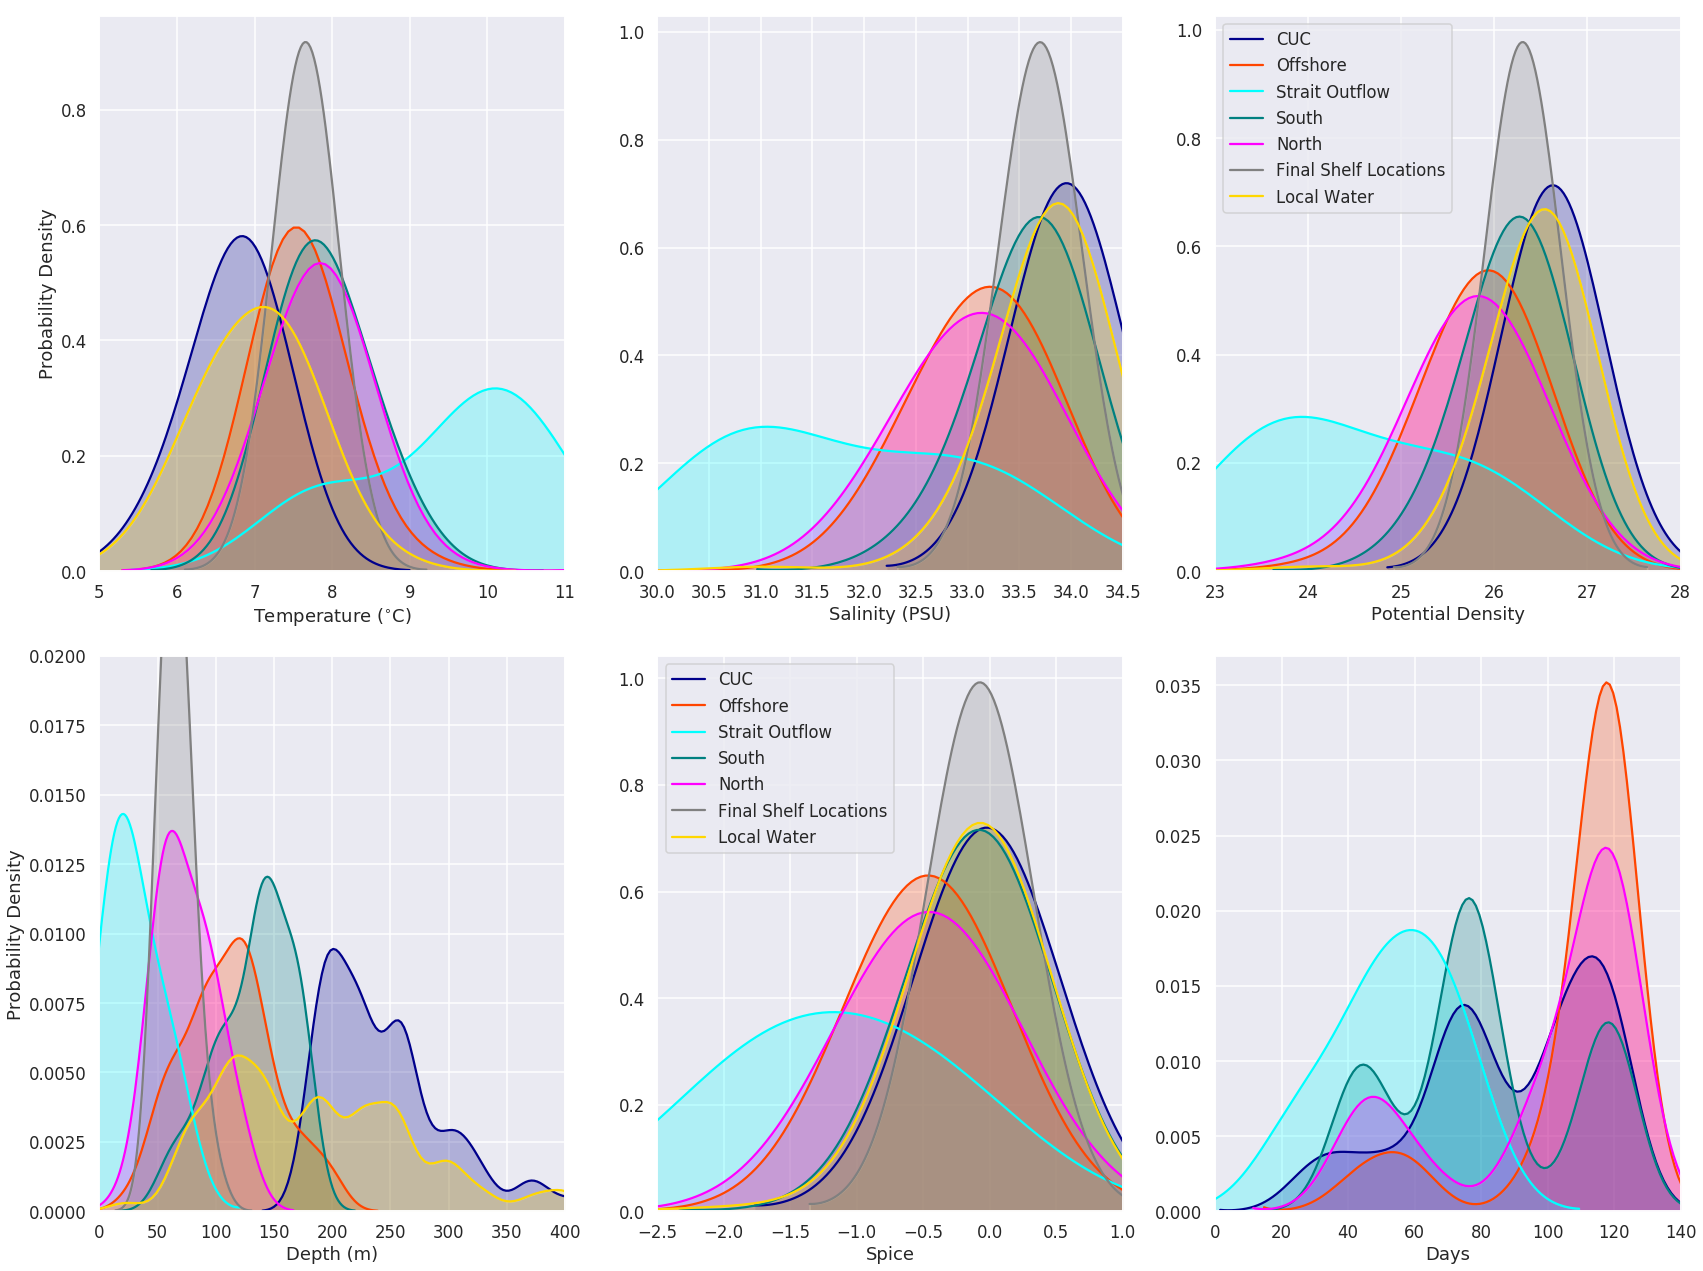

In [35]:
df = pd.DataFrame()

d = 1
local_percent = (ind_local.shape[0]/final_z.shape[0])*100

df['Density CUC']     = traj_rho_final_cuc
df['Temperature CUC'] = traj_tem_final_cuc
df['Salinity CUC']    = traj_sal_final_cuc
df['Spice CUC']       = spic_loc_cuc
df['Depth CUC']       = -traj_depth_final_cuc

dp = pd.DataFrame()

dp['Density OFF']     = traj_rho_final_off
dp['Temperature OFF'] = traj_tem_final_off
dp['Salinity OFF']    = traj_sal_final_off
dp['Spice OFF']       = spic_loc_off
dp['Depth OFF']       = -traj_depth_final_off

dg = pd.DataFrame()

dg['Density South']     = traj_rho_final_south
dg['Temperature South'] = traj_tem_final_south
dg['Salinity South']    = traj_sal_final_south
dg['Spice South']       = spic_loc_south
dg['Depth South']       = -traj_depth_final_south

dh = pd.DataFrame()

dh['Density Juan']     = traj_rho_final_juan
dh['Temperature Juan'] = traj_tem_final_juan
dh['Salinity Juan']    = traj_sal_final_juan
dh['Spice Juan']       = spic_loc_juan
dh['Depth Juan']       = -traj_depth_final_juan


dq = pd.DataFrame()

dq['Density North']     = traj_rho_final_north
dq['Temperature North'] = traj_tem_final_north
dq['Salinity North']    = traj_sal_final_north
dq['Spice North']       = spic_loc_north
dq['Depth North']       = -traj_depth_final_north


da = pd.DataFrame()

da['Density Init']     = traj_rho_init
da['Temperature Init'] = traj_tem_init
da['Salinity Init']    = traj_sal_init
da['Spice Init']       = spic_loc_init
da['Depth Init']       = -traj_depth_init

dj = pd.DataFrame()

dj['Density Local']     = traj_rho_final_local
dj['Temperature Local'] = traj_tem_final_local
dj['Salinity Local']    = traj_sal_final_local
dj['Spice Local']       = spic_loc_local
dj['Depth Local']       = -traj_depth_final_local


fig, (ax1,ax2) = plt.subplots(2,3, figsize=(24,18), sharey = False)

q = sns.kdeplot(df['Temperature CUC'], ax = ax1[0],bw=(cuc_percent**(-1./(d+4))),shade=True, color = 'darkblue', label = 'CUC')

sns.kdeplot(dp['Temperature OFF'], ax = ax1[0], bw=(off_percent**(-1./(d+4))),shade=True, color = 'orangered', label = 'Offshore')

sns.kdeplot(dh['Temperature Juan'], ax = ax1[0], bw=(juan_percent**(-1./(d+4))), shade= True, color = 'Cyan', label = 'Strait Outflow')

sns.kdeplot(dg['Temperature South'], ax = ax1[0], bw=(south_percent**(-1./(d+4))),shade=True, color = 'Teal', label = 'South')

sns.kdeplot(dq['Temperature North'], ax = ax1[0], bw=(north_percent**(-1./(d+4))),shade=True, color = 'Magenta', label = 'North')

sns.kdeplot(da['Temperature Init'], ax = ax1[0], bw =(100**(-1./(d+4))), shade=True, color = 'Gray', label = None)

sns.kdeplot(dj['Temperature Local'], ax = ax1[0], bw =(local_percent**(-1./(d+4))), shade=True, color = 'Gold', label = None)


ax1[0].set_xlim(5,11)
ax1[0].set_xlabel('Temperature ($^{\circ}$C)')
ax1[0].set_ylabel('Probability Density')
ax1[0].get_legend().remove()
ax1[0].grid()


q = sns.kdeplot(df['Salinity CUC'], ax = ax1[1], bw=(cuc_percent**(-1./(d+4))),  shade=True, color = 'darkblue', label = 'CUC')

sns.kdeplot(dp['Salinity OFF'], ax = ax1[1], bw = (off_percent**(-1./(d+4))),  shade=True,color = 'orangered', label = 'Offshore')

sns.kdeplot(dh['Salinity Juan'], ax = ax1[1], bw = (juan_percent**(-1./(d+4))), shade= True, color = 'Cyan', label = 'Strait Outflow')

sns.kdeplot(dg['Salinity South'], ax = ax1[1],  bw = (south_percent**(-1./(d+4))), shade=True, color = 'Teal', label = 'South')

sns.kdeplot(dq['Salinity North'], ax = ax1[1],bw = (north_percent**(-1./(d+4))), shade=True, color = 'Magenta', label = 'North')

sns.kdeplot(da['Salinity Init'], ax = ax1[1], bw = (100**(-1./(d+4))), shade=True, color = 'Gray',label = None)

sns.kdeplot(dj['Salinity Local'], ax = ax1[1], bw =(local_percent**(-1./(d+4))), shade=True, color = 'Gold', label = None)

# p = sns.relplot(x="Observed_temp", y="Model_temp", hue="Depth (m)",  sizes=(1,10), data=df, legend='brief', palette=cmo.cm.amp_r)

# q.figure.axes[-1].yaxis.label.set_size(16)
# q.figure.axes[-1].tick_params(labelsize=16) 


# ax1.legend()
# ax1.tick_params(axis='both',labelsize =16)
# ax1.set_xlabel('Temperature', fontsize = 16)
# ax1.set_ylabel('Density', fontsize = 16)
ax1[1].set_xlim(30,34.5)
ax1[1].set_xlabel('Salinity (PSU)')
# ax2.set_ylabel('Density')
ax1[1].grid()
# ax1[2].legend()
ax1[1].get_legend().remove()


q = sns.kdeplot(df['Density CUC'], ax = ax1[2], bw=(cuc_percent**(-1./(d+4))), shade=True, color = 'darkblue', label = 'CUC')

sns.kdeplot(dp['Density OFF'], ax = ax1[2],bw=(off_percent**(-1./(d+4))) ,shade=True,color = 'orangered', label = 'Offshore')

sns.kdeplot(dh['Density Juan'], ax = ax1[2], bw=(juan_percent**(-1./(d+4))),shade= True, color = 'Cyan', label = 'Strait Outflow')

sns.kdeplot(dg['Density South'], ax = ax1[2], bw=(south_percent**(-1./(d+4))), shade=True, color = 'Teal', label = 'South')

sns.kdeplot(dq['Density North'], ax = ax1[2], bw=(north_percent**(-1./(d+4))),shade=True, color = 'Magenta', label = 'North')

sns.kdeplot(da['Density Init'], ax = ax1[2], bw=(100**(-1./(d+4))), shade=True, color = 'Gray',label = 'Final Shelf Locations')

sns.kdeplot(dj['Density Local'], ax = ax1[2], bw =(local_percent**(-1./(d+4))), shade=True, color = 'Gold', label = 'Local Water')

# p = sns.relplot(x="Observed_temp", y="Model_temp", hue="Depth (m)",  sizes=(1,10), data=df, legend='brief', palette=cmo.cm.amp_r)

# q.figure.axes[-1].yaxis.label.set_size(16)
# q.figure.axes[-1].tick_params(labelsize=16) 


# ax1.legend()
# ax1.tick_params(axis='both',labelsize =16)
# ax1.set_xlabel('Temperature', fontsize = 16)
# ax1.set_ylabel('Density', fontsize = 16)
ax1[2].set_xlim(23,28)
ax1[2].set_xlabel('Potential Density')
# ax2.set_ylabel('Density')
ax1[2].grid()
ax1[2].legend()
# ax1[2].get_legend().remove()


q = sns.kdeplot(df['Depth CUC'], ax = ax2[0], bw=((cuc_percent/10000000)**(-1./(d+4))), shade=True, color = 'darkblue', label = 'CUC')

sns.kdeplot(dp['Depth OFF'], ax = ax2[0], bw=((off_percent/10000000)**(-1./(d+4))), shade=True, color = 'orangered', label = 'Offshore')

sns.kdeplot(dg['Depth South'], ax = ax2[0], bw=((south_percent/10000000)**(-1./(d+4))), shade= True, color = 'Teal', label = 'South')

sns.kdeplot(dh['Depth Juan'], ax = ax2[0], bw=((juan_percent/10000000)**(-1./(d+4))),  shade=True, color = 'Cyan', label = 'Staright Outflow')

sns.kdeplot(dq['Depth North'], ax = ax2[0],  bw=((north_percent/10000000)**(-1./(d+4))), shade=True, color = 'Magenta', label = 'North')

sns.kdeplot(da['Depth Init'], ax = ax2[0], bw=((100/10000000)**(-1./(d+4))), shade=True, color = 'Gray', label = False)

sns.kdeplot(dj['Depth Local'], ax = ax2[0], bw =(local_percent/0.05**(-1./(d+4))), shade=True, color = 'Gold', label = None)

# p = sns.relplot(x="Observed_temp", y="Model_temp", hue="Depth (m)",  sizes=(1,10), data=df, legend='brief', palette=cmo.cm.amp_r)

# q.figure.axes[-1].yaxis.label.set_size(16)
# q.figure.axes[-1].tick_params(labelsize=16) 

# lims = [
#     np.min([ax1.get_xlim(), ax1.get_ylim()]),  # min of both axes
#     np.max([ax1.get_xlim(), ax1.get_ylim()]),  # max of both axes
# ]


# ax2[0].legend()
# ax1.tick_params(axis='both',labelsize =16)
# ax1.set_xlabel('Temperature', fontsize = 16)
# ax1.set_ylabel('Density', fontsize = 16)
# ax1.set_xlim(6,14)
ax2[0].set_xlabel('Depth (m)')
ax2[0].set_ylabel('Probability Density')
ax2[0].grid()

ax2[0].set_xlim(0,400)
ax2[0].set_ylim(0,0.02)
ax2[0].get_legend().remove()


q = sns.kdeplot(df['Spice CUC'], ax = ax2[1], bw=(cuc_percent**(-1./(d+4))), shade=True, color = 'darkblue', label = 'CUC')

sns.kdeplot(dp['Spice OFF'], ax = ax2[1], bw=(off_percent**(-1./(d+4))), shade=True,color = 'orangered', label = 'Offshore')

sns.kdeplot(dh['Spice Juan'], ax = ax2[1], bw=(juan_percent**(-1./(d+4))), shade= True, color = 'Cyan', label = 'Strait Outflow')

sns.kdeplot(dg['Spice South'], ax = ax2[1],  bw=(south_percent**(-1./(d+4))), shade=True, color = 'Teal', label = 'South')

sns.kdeplot(dq['Spice North'], ax = ax2[1],  bw=(north_percent**(-1./(d+4))),shade=True, color = 'Magenta', label = 'North')

sns.kdeplot(da['Spice Init'], ax = ax2[1], bw=(100**(-1./(d+4))), shade=True, color = 'Gray', label = 'Final Shelf Locations')

sns.kdeplot(dj['Spice Local'], ax = ax2[1], bw =(local_percent**(-1./(d+4))), shade=True, color = 'Gold', label = 'Local Water')


# p = sns.relplot(x="Observed_temp", y="Model_temp", hue="Depth (m)",  sizes=(1,10), data=df, legend='brief', palette=cmo.cm.amp_r)

# q.figure.axes[-1].yaxis.label.set_size(16)
# q.figure.axes[-1].tick_params(labelsize=16) 


# ax1.legend()
# ax1.tick_params(axis='both',labelsize =16)
# ax1.set_xlabel('Temperature', fontsize = 16)
# ax1.set_ylabel('Density', fontsize = 16)
ax2[1].set_xlim(-2.5,1)
ax2[1].set_xlabel('Spice')
# ax2.set_ylabel('Density')
ax2[1].grid()
ax2[1].legend()
# ax2[1].get_legend().remove()




df = pd.DataFrame()

df['Days CUC']     = traj_days_final_cuc


dp = pd.DataFrame()

dp['Days OFF']     = traj_days_final_off


dg = pd.DataFrame()

dg['Days South']     = traj_days_final_south


dh = pd.DataFrame()

dh['Days Juan']     = traj_days_final_juan

dz = pd.DataFrame()

dz['Days North']    = traj_days_final_north

dn = pd.DataFrame()

dn['Days Local'] = traj_days_final_local




q = sns.kdeplot(df['Days CUC'], ax = ax2[2],  bw=((cuc_percent/1000000)**(-1./(d+4))), shade=True, color = 'darkblue', label = 'CUC')

sns.kdeplot(dp['Days OFF'], ax = ax2[2], bw=((off_percent/1000000)**(-1./(d+4))), shade=True, color = 'orangered', label = 'Offshore')

sns.kdeplot(dg['Days South'], ax = ax2[2], bw=((south_percent/1000000)**(-1./(d+4))), shade= True, color = 'Teal', label = 'South')

sns.kdeplot(dh['Days Juan'], ax = ax2[2], bw=((juan_percent/1000000)**(-1./(d+4))), shade=True, color = 'Cyan', label = 'Strait Outflow')

sns.kdeplot(dz['Days North'], ax = ax2[2],  bw=((north_percent/1000000)**(-1./(d+4))), shade=True, color = 'Magenta', label = 'North')

# sns.kdeplot(dn['Days Local'], ax = ax2[2], bw =(local_percent/0.001**(-1./(d+4))), shade=True, color = 'Gold', label = None)

# p = sns.relplot(x="Observed_temp", y="Model_temp", hue="Depth (m)",  sizes=(1,10), data=df, legend='brief', palette=cmo.cm.amp_r)

# q.figure.axes[-1].yaxis.label.set_size(16)
# q.figure.axes[-1].tick_params(labelsize=16) 



# ax1.legend()
# ax1.tick_params(axis='both',labelsize =16)
# ax1.set_xlabel('Temperature', fontsize = 16)
# ax1.set_ylabel('Density', fontsize = 16)
# ax1.set_xlim(6,14)
ax2[2].set_xlabel('Days')
# ax1.set_ylabel('Probability Density')
ax2[2].grid()
ax2[2].get_legend().remove()
# ax2[2].legend()

ax2[2].set_xlim(0,140)

fig.tight_layout()


(5, 12)

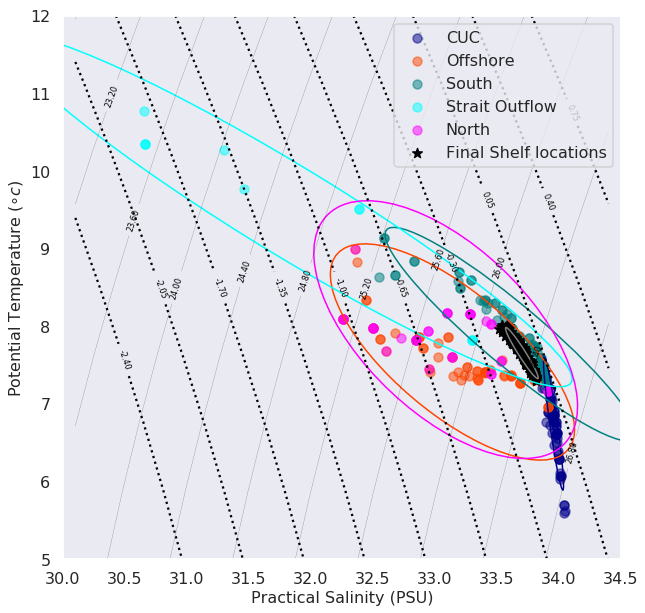

In [36]:
# colors = cmo.cm.phase(np.linspace(0, 1, 200))


# traj_sal_domain = traj_sal[traj_sal != 1.0100000202412861e+20]
# traj_tem_domain = traj_tem[traj_sal != 1.0100000202412861e+20]

# smin = np.nanmin(traj_sal_last)  - (0.01 * np.nanmin(traj_sal_last))
smin = 30
smax = np.nanmax(traj_sal_last)  + (0.01 * np.nanmax(traj_sal_last))
# tmin = np.nanmin(traj_tem_last) - (0.1 * np.nanmax(traj_tem_last))
tmin = 4
tmax = 12
# tmax = np.nanmax(traj_tem_last) + (0.1 * np.nanmax(traj_tem_last))
 
# Calculate how many gridcells we need in the x and y dimensions
xdim = int(round((smax-smin)/0.1+1,0))
ydim = int(round((tmax-tmin)+1,0))
 
# Create empty grid of zeros
dens_1 = np.empty((ydim,xdim))
spic_1 = np.empty((ydim,xdim))
SA = np.empty((xdim))
CT = np.empty((ydim)) 
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(1,ydim-1,ydim)+tmin
si = np.linspace(1,xdim-1,xdim)*0.1+smin
 
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        
        SA[i] = gsw.SA_from_SP(si[i], 0, np.mean(traj_lon), np.mean(traj_lat))

        CT[j] = gsw.CT_from_pt(si[i], ti[j])
        
        dens_1[j,i]=gsw.rho(SA[i],CT[j],0)
        
        spic_1[j,i] = gsw.spiciness0(SA[i],CT[j])
 
# Substract 1000 to convert to sigma-t
dens_1 = dens_1 - 1000;
 
# Plot data ***********************************************
fig1, ax = plt.subplots(1, 1, figsize=(10,10))
CS = ax.contour(si,ti,dens_1, np.arange(22.4,27,0.4), linestyles='dashed', linewidths = 0.2,colors='k')
CS1 = ax.contour(si,ti,spic_1,np.arange(-2.4,1,0.35), linestyles='dotted', colors='k')
plt.clabel(CS, fontsize=8, inline=1, fmt='%0.2f') # Label every second level
plt.clabel(CS1, fontsize=8, inline=1, fmt='%0.2f') # Label every second level



ax.scatter(traj_sal_final_cuc, traj_tem_final_cuc, s=80, alpha=0.5, c = 'darkblue', label = 'CUC')
sal_mean_cuc = np.mean(traj_sal_final_cuc)
tem_mean_cuc = np.mean(traj_tem_final_cuc)
cov_cuc = np.cov(traj_sal_final_cuc, traj_tem_final_cuc)
cuc_ell = get_cov_ellipse(cov_cuc, (sal_mean_cuc, tem_mean_cuc), 2,
                    ec='darkblue', fc = None)
cuc_ell.set_facecolor('none')
ax.add_artist(cuc_ell)




ax.scatter(traj_sal_final_off, traj_tem_final_off, s=80, alpha=0.5, c = 'orangered', label = 'Offshore')
sal_mean_off = np.mean(traj_sal_final_off)
tem_mean_off = np.mean(traj_tem_final_off)
cov_off = np.cov(traj_sal_final_off, traj_tem_final_off)
off_ell = get_cov_ellipse(cov_off, (sal_mean_off, tem_mean_off), 2,
                    ec='orangered', fc = None)
off_ell.set_facecolor('none')
ax.add_artist(off_ell)


traj_tem_final_north = traj_tem_final_north[traj_sal_final_north > 30]
traj_sal_final_north = traj_sal_final_north[traj_sal_final_north > 30]

ax.scatter(traj_sal_final_south, traj_tem_final_south, s=80, alpha=0.5, c= 'Teal', label = 'South')
sal_mean_south = np.mean(traj_sal_final_south)
tem_mean_south = np.mean(traj_tem_final_south)
cov_south = np.cov(traj_sal_final_south, traj_tem_final_south)
south_ell = get_cov_ellipse(cov_south, (sal_mean_south, tem_mean_south), 3,
                    ec='Teal', fc = None)
south_ell.set_facecolor('none')
ax.add_artist(south_ell)




# traj_tem_final_juan = traj_tem_final_juan[traj_sal_final_juan < 32.8]
# traj_sal_final_juan = traj_sal_final_juan[traj_sal_final_juan < 32.8]

ax.scatter(traj_sal_final_juan, traj_tem_final_juan, s=80, alpha=0.5, c = 'cyan', label = 'Strait Outflow')
sal_mean_juan = np.mean(traj_sal_final_juan)
tem_mean_juan = np.mean(traj_tem_final_juan)
cov_juan = np.cov(traj_sal_final_juan, traj_tem_final_juan)
juan_ell = get_cov_ellipse(cov_juan, (sal_mean_juan, tem_mean_juan), 2,
                    fc = None, ec='cyan')
juan_ell.set_facecolor('none')
ax.add_artist(juan_ell)




ax.scatter(traj_sal_final_north, traj_tem_final_north, s=80, alpha=0.5, c = 'Magenta', label = 'North')
sal_mean_north = np.mean(traj_sal_final_north)
tem_mean_north = np.mean(traj_tem_final_north)
cov_north = np.cov(traj_sal_final_north, traj_tem_final_north)
north_ell = get_cov_ellipse(cov_north, (sal_mean_north, tem_mean_north), 2,
                    ec='Magenta', fc = None)
north_ell.set_facecolor('none')
ax.add_artist(north_ell)

# traj_tem_final_local = traj_tem_final_local[traj_sal_final_local > 30]
# traj_sal_final_local = traj_sal_final_local[traj_sal_final_local > 30]

# ax.scatter(traj_sal_final_local, traj_tem_final_local, s=80, alpha=0.5, c = 'Gold', label = 'Local Water')
# sal_mean_local = np.mean(traj_sal_final_local)
# tem_mean_local = np.mean(traj_tem_final_local)
# cov_local = np.cov(traj_sal_final_local, traj_tem_final_local)
# local_ell = get_cov_ellipse(cov_local, (sal_mean_local, tem_mean_local), 2,
#                     ec='Gold', fc = None)
# local_ell.set_facecolor('none')
# ax.add_artist(local_ell)


traj_tem_init = traj_tem_init[traj_sal_init > 30]
traj_sal_init = traj_sal_init[traj_sal_init > 30]

ax.scatter(traj_sal_init, traj_tem_init, s=100, marker='*', c = 'k', label = "Final Shelf locations")#'chartreuse')
sal_mean_init = np.mean(traj_sal_init)
tem_mean_init = np.mean(traj_tem_init)
cov_init = np.cov(traj_sal_init, traj_tem_init)
init_ell = get_cov_ellipse(cov_init, (sal_mean_init, tem_mean_init), 2,
                    ec='gray', fc = None)
init_ell.set_facecolor('none')
ax.add_artist(init_ell)


ax.legend(loc = 'best', fontsize = 16)


 
ax.set_xlabel('Practical Salinity (PSU)', fontsize = 16)
ax.set_ylabel('Potential Temperature ($\circ c$)', fontsize = 16)
ax.tick_params(axis='both',labelsize =16)
ax.set_xlim(30,34.5)
ax.set_ylim(5,12)


# legend = ax.legend(loc='upper right', fancybox=True, framealpha=0.25)

In [36]:
IK = find_index(500)

PK = find_index(1000)

# LK = find_index(1500)

# JK = find_index(2000)

# LI = find_index(2500)

# LP = find_index(3000)

# MN = find_index(3500)

total_indi_high = np.concatenate((IK,PK))#,LK,JK,LI, LP, MN))

In [37]:
cross_index_high = []


for i in np.unique(total_indi_high):

    if ((np.max(-traj_depth[:,i]) >= 200) & (np.min(-traj_depth[:,i]) < 200)) == True:
        
        cross_index_high = np.append(arr=cross_index_high, values=i)
        


In [54]:
final_age.shape

(363,)

In [55]:
cross_index_high.shape

(125,)

In [57]:
percentage = cross_index_high.shape[0]/final_age_days.shape[0]

print(percentage)

0.3443526170798898


### 34.4 percent of the south outer shelf water has arrived to the final locations via upwelling (our definition)

In [38]:
time_index_high = np.empty_like(cross_index_high)

for k in np.arange(cross_index_high.shape[0]):
    time_index_high[k] = np.min(np.argwhere(-traj_depth[:,cross_index_high[k].astype(int)] > 200))
    
    

In [59]:
np.save(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/numpy_arrays_saved/cross_index_accurate_iso_high.npy', \
        arr=cross_index_high)

np.save(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/numpy_arrays_saved/time_index_accurate_iso_high.npy',\
        arr=time_index_high)


In [39]:
x_200_total = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/numpy_arrays_saved/\
x_200_south_outer_shelf_water_acc_iso.npy')

y_200_total  = np.load(file='/data/ssahu/NEP36_2013_summer_hindcast/Ariane_files/numpy_arrays_saved/\
y_200_south_outer_shelf_water_acc_iso.npy')

/home/ssahu/anaconda3/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


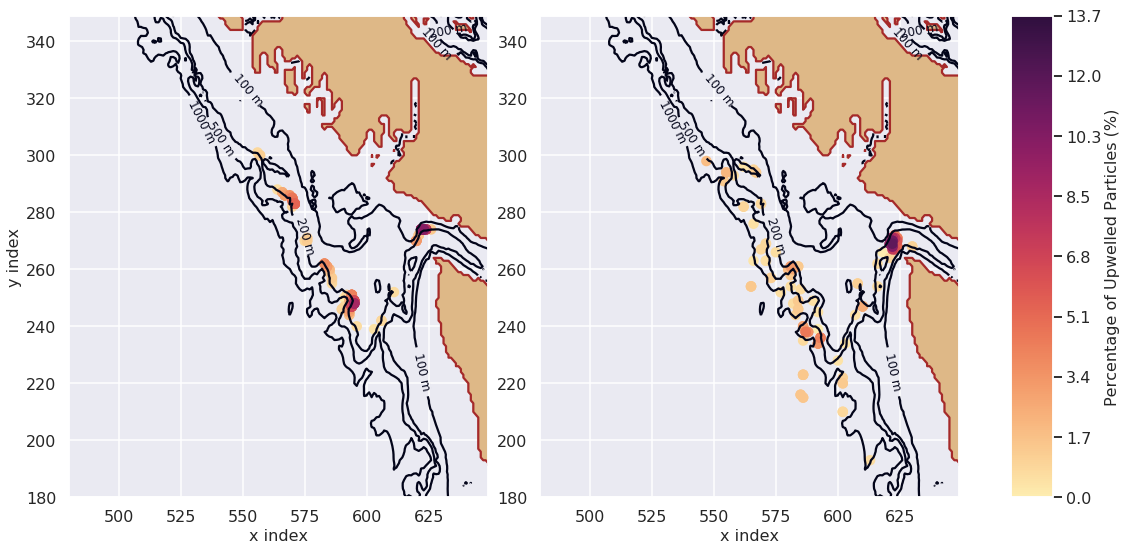

In [48]:
from scipy.interpolate import interpn
from mpl_toolkits.axes_grid1 import make_axes_locatable





cmap = plt.get_cmap(cmo.cm.matter)


bathy = nc.Dataset('/data/mdunphy/NEP036-N30-OUT/INV/Bathymetry_EastCoast_NEMO_R036_GEBCO_corr_v14.nc')

Z = bathy.variables['Bathymetry']


lon = bathy['nav_lon'][...]
lat = bathy['nav_lat'][...]




# cmap=plt.cm.get_cmap('nipy_spectral')
# cmap = plt.cm.get_cmap('gist_rainbow_r')
cmap.set_bad('#8b7765')
vmin = 0
vmax = 20

import matplotlib as mpl

gridspec = {'width_ratios': [1, 1, 0.1]}

fig, ax = plt.subplots(1, 3, figsize=(16, 8), gridspec_kw=gridspec)


# fig, (ax1,ax) = plt.subplots(1, 2, figsize=(12,8), sharey=True); 

ax[0].grid()

CS1 = ax[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,110,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)


CS1 = ax[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(200,210,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(1000,1010,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax[0].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(500,510,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)



ax[0].set_xlabel('x index', fontsize =16)
ax[0].set_ylabel('y index', fontsize = 16)
ax[0].tick_params(axis='both',labelsize =16)

ax[0].legend(loc = 'best')

viz_tools.plot_land_mask(ax[0], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
viz_tools.plot_coastline(ax[0], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')


lon_LB08 = -125.4775
lat_LB08 = 48.4217

j, i = geo_tools.find_closest_model_point(lon_LB08,lat_LB08,\
                                          lon,lat,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 


q = density_scatter(x_200_total[~np.isnan(y_200_total)], y_200_total[~np.isnan(y_200_total)], ax= ax[0], bins = [30,30], cmap = cmap , vmin = vmin, vmax = vmax)

ax[0].grid()


# Line = ax[0].plot(x_200_wcvi[::1], y_200_wcvi[::1], 'k-')



ax[1].grid()


CS1 = ax[1].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(100,110,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax[1].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(200,210,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax[1].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(1000,1010,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)

CS1 = ax[1].contour(x_wcvi_slice,y_wcvi_slice,Z[y_wcvi_slice,x_wcvi_slice], np.arange(500,510,10))
CLS1 = plt.clabel(CS1, inline=3,fmt='%0.0f m', fontsize=12)




ax[1].set_xlabel('x index', fontsize =16)
# ax.set_ylabel('y index', fontsize = 16)
ax[1].tick_params(axis='both',labelsize =16)



ax[1].legend(loc = 'best')

viz_tools.plot_land_mask(ax[1], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='burlywood')
viz_tools.plot_coastline(ax[1], bathy, yslice=y_wcvi_slice, xslice=x_wcvi_slice, color='brown')



# ax.vlines(x = 635, ymin = 261, ymax = 279, color = 'blue')

# ax.get_legend().remove()
lon_LB08 = -125.4775
lat_LB08 = 48.4217

j, i = geo_tools.find_closest_model_point(lon_LB08,lat_LB08,\
                                          lon,lat,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 


x_up = []
y_up = []

for k in np.arange(cross_index_high.shape[0]):
    y_p, x_p = geo_tools.find_closest_model_point(traj_lon[time_index_high[k].astype(int), cross_index_high[k].astype(int)],\
                                          traj_lat[time_index_high[k].astype(int), cross_index_high[k].astype(int)],\
                                          lon,lat,grid='NEMO',tols=\
                                          {'NEMO': {'tol_lon': 0.1, 'tol_lat': 0.1},\
                                           'GEM2.5': {'tol_lon': 0.1, 'tol_lat': 0.1}}) 
    
    y_up = np.append(arr=y_up, values=y_p)
    x_up = np.append(arr=x_up, values=x_p)


q = density_scatter(x_up, y_up, ax= ax[1], bins = [30,30], cmap = cmap , vmin = vmin, vmax = vmax)

ax[1].grid()


# Line = ax[1].plot(x_200_wcvi[::1], y_200_wcvi[::1], 'm-')



m = cm.ScalarMappable(cmap=cmap)
m.set_array(q)
m.set_clim(vmin,vmax)
# plt.colorbar(m, cax=ax[2])

cbar = fig.colorbar(m, cax=ax[2])#, format=ticker.FuncFormatter(fmt))


cbar.ax.set_yticklabels(np.around(a=np.linspace(start=(cbar.vmin/cross_index_high.shape[0])*100, \
                                    stop=(cbar.vmax/cross_index_high.shape[0])*100, num=10), decimals = 1))

cbar.set_label(label='Percentage of Upwelled Particles (%)', fontsize = 16)
cbar.ax.tick_params(labelsize=16)

fig.tight_layout(h_pad=0.01,w_pad=0.01)

